## Objective

Do a deep dive into data cleaning of credit score dataset from perspective of predictive modelling. Explore and ponder about the standard methods used to detect problematic points.

## Summary of what you will find

- In this notebook, you will able to see how an unclean data can be transformed into a clean data using not just only standard outlier detection methods or standard imputations but a thoughtful analysis of choosing the right measures for the right task depending upon the patterns existing wihtin the data.  
- Implementation of techniques like IQR, median standardization for outlier detection and how to use the patterns or chronolgical structure within data to make better guesses.  
- A deep dive into each column about what can be done to clean the data, fill the missing values and how can we actually implement that.  
- Litlle bit of feature engineering from the perspective of predictive modelling.
- Custom functions which increase resuability in other projects as well.
- Doing outlier detections or erroneous value detections using single columns or referring multiple columns to fill or correct the values.  
- Minor things like shuffling data and exporting it into csv will also be shown.

## Importing Libraries

In [956]:
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install seaborn

In [957]:

# General Packages
import os

# data hanlding libraries
import numpy as np
import pandas as pd

# visulaization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# extra libraries
import warnings
warnings.filterwarnings('ignore')

## Loading the dataset

In [958]:
# Load data from a folder called data within my project file
#  .. my_project
#     |
#     |___code
#     |   |
#     |   |__ CS3500_Starter_Notebook.ipynb
#     |
#     |___data
#         |
#         |__ credit_score.csv
#
#---------------------------------------------------------------

# Get the current working directory
current_dir = os.getcwd() 

# Construct a path to the parent directory
parent_dir = os.path.join(current_dir, "..")

# Access a file in the parent directory
file_path = os.path.abspath(os.path.join(parent_dir, "data", "credit_score_data.csv"))    #data\credit_score_data.csv

# Load Credit Score data
df = pd.read_csv(file_path) 

## Understanding the dataset

In [959]:
df.head()

,Unnamed: 0,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good


In [960]:
df.shape

(80000, 29)

Total 80,000 record of customers are available with 28 features(including the target feature).

In [961]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 29 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                80000 non-null  int64  
 1   ID                        80000 non-null  object 
 2   Customer_ID               80000 non-null  object 
 3   Month                     80000 non-null  object 
 4   Name                      71988 non-null  object 
 5   Age                       80000 non-null  object 
 6   SSN                       80000 non-null  object 
 7   Occupation                80000 non-null  object 
 8   Annual_Income             80000 non-null  object 
 9   Monthly_Inhand_Salary     68024 non-null  float64
 10  Num_Bank_Accounts         80000 non-null  int64  
 11  Num_Credit_Card           80000 non-null  int64  
 12  Interest_Rate             80000 non-null  int64  
 13  Num_of_Loan               80000 non-null  object 
 14  Type_o

Looks like the data consists of a brief history of credit score for some customers over some period of months. With each month per customer as one record.

Lets ask some basic questions to understand the data better.

In [962]:
# How many customers are present?
df['Customer_ID'].nunique()

10000

There are 10,000 customers in the dataset.

In [963]:
# How many unique months are there?
#df['Month'].nunique()

There are 8 unique months in there. What are the counts of each? Ideally, it should be 10000 count for each month, corresponding to each customer if the data is present for same 8-month period for each.

In [964]:
#df['Month'].value_counts()

Ok. But this still doesn't confirm that we have data of same 8-months period for each customer? What we can do is count number of unique months for each customer after grouping by customer id. Count should be 8 for each customer.

In [965]:
df.groupby('Customer_ID')['Month'].nunique().value_counts()

Month
8    10000
Name: count, dtype: int64

Also, if we extract the year and month from 'Credit_History_Age' and convert it into total months then the difference in between two consecutive months should always be 1.

In [966]:
temp_df = df['Credit_History_Age'].str.extract('(?P<Years>\d+) Years and (?P<Months>\d+) Months').astype(float)
temp_df['Customer_ID'] = df['Customer_ID'] 
temp_df['Total_months'] = temp_df['Years'] * 12 + temp_df['Months']
temp_df.groupby('Customer_ID')['Total_months'].transform(pd.Series.diff).unique()

array([nan,  1.])

We have confirmed that each customer has a 8-month time period window for which the data is given in the dataset.

Now, lets look at whether the credit scores are same throughout the 8-month period for each customer or do they vary?

In [967]:
df.groupby('Customer_ID')['Credit_Score'].nunique().value_counts()

Credit_Score
2    5843
1    4135
3      22
Name: count, dtype: int64

So, throughout the 8-months period for a customer it can happen that the credit score stays the same or varies. That means depending upon any current months situation and past history as well, a customer can be classified in different credit score brackets.

## Custom Functions

In [968]:
def describe_numerical_column(series, col_name):
    """
    Describe a numerical column using the describe function of a series,
    report the number of null values, and return min, max, IQR-based
    outlier lower range, and IQR-based outlier upper range as a dictionary.
    """
    # Statistical description of the series
    description = series.describe()
    num_null_values = series.isnull().sum()

    print(description, end='\n\n')
    print(f'Number of null values: {num_null_values}', '\n\n')

    # Calculate IQR
    q1, q3 = series.quantile([0.25, 0.75])
    IQR = q3 - q1
    
    # Return a dictionary with computed values
    return {
        'Min. value': series.min(),
        'Outlier lower range': q1 - 1.5 * IQR,
        'Outlier upper range': q3 + 1.5 * IQR,
        'Max. value': series.max()
    }


def summarize_numerical_column_with_deviation(data, num_col, group_col='Customer_ID', absolute_summary=True, median_standardization_summary=False):
    """
    Summarize the numerical column and its median standardization
    based on customers using the describe_numerical_column function.
    """
    Summary_dict = {}
    
    # Absolute summary
    if absolute_summary:
        print(f'Column description for {num_col}:\n')
        Summary_dict[num_col] = describe_numerical_column(data[num_col], num_col)
    
    # Median standardization summary
    if median_standardization_summary:
        if absolute_summary:
            print('\n')
        default_MAD = return_max_MAD(data, num_col, group_col)
        num_col_standardization = data.groupby(group_col)[num_col].apply(
            median_standardization, default_value=default_MAD
        )
        print(f'Median standardization for {num_col}:\n')
        Summary_dict[f'Median standardization of {num_col}'] = describe_numerical_column(
            num_col_standardization, f'Median standardization of {num_col}'
        )
        Summary_dict['Max. MAD'] = default_MAD
    
    return Summary_dict



def return_max_MAD(data, num_col, group_col = 'Customer_ID'):
    '''Return max value of median absolute devaition(MAD) from within the customers for num_col'''
    return (data.groupby(group_col)[num_col].agg(lambda x: (x - x.median()).abs().median())).max()
    
def validate_age(x):
    '''Check whether 8-months period age for a customer is logically valid or not'''
    diff = x.diff()
    if (diff == 0).sum() == 7:
        return True
    elif ((diff.isin([0, 1])).sum() == 7) and ((diff == 1).sum() == 1):
        return True
    else:
        return False
        
def median_standardization(x, default_value):
    '''Transform series or dataframe to its devaition from median with respect to Median absolute deviation(MAD) i.e. median standardization.'''
    med = x.median() 
    abs = (x - med).abs()
    MAD = abs.median()
    if MAD == 0:
        if ((abs == 0).sum() == abs.notnull().sum()): # When MAD is zero and all non-null values are constant in x
            return x * 0
        else:
            return (x - med)/default_value # When MAD is zero but all non-values are not same in x
    else:
        return (x - med)/MAD # When MAD is non-zero

def return_num_of_modes(x):
    '''Return number of modes in given series or dataframe'''
    return len(x.mode())

def return_mode(x):
    '''Return nan if no mode exists in given series or return minimum mode'''
    modes = x.mode()
    if len(modes) == 0:
        return np.nan
    return modes.min()

def forward_backward_fill(x):
    '''Perform forward fill then backward fill on given series or dataframe'''
    return x.fillna(method='ffill').fillna(method='bfill')

def return_mode_median_filled_int(x):
    '''Return back series by filling with mode(in case there is one mode) else fill with integer part of median'''
    modes = x.mode()
    if len(modes) == 1:
        return x.fillna(modes[0])
    else:
        return x.fillna(int(modes.median()))

def return_mode_average_filled(x):
    '''Return back series by filling with mode(in case there is one mode) else fill with average of modes'''
    modes = x.mode()
    if len(modes) == 1:
        return x.fillna(modes[0])
    else:
        return x.fillna(modes.mean())

def fill_month_history(x):
    '''Return months filled data for 8-months period'''
    first_non_null_idx = x.argmin()
    first_non_null_value = x.iloc[first_non_null_idx]
    return pd.Series(first_non_null_value + np.array(range(-first_non_null_idx, 8-first_non_null_idx)), index = x.index)

## Dataset pre-processing

### Dropping unnecessary columns, data cleaning and correcting data types

**Note:**  
Ideally data cleaning should be done in parallel to discussions with domain expert to understand what values are appropriate in the columns, can they be retrieved if missing and do the columns depend upon each other. Unfortunately, such kind of support is not available in this kaggle project and therefore, we will deal with the data as per our understanding approximately.

Looking at the dataset info, many of the columns in our dataset have null values within them, representing missing values. Also, some columns are not of the correct data type as per the data they hold, this means there might be some textual characters within the data indicating unclean data and maybe placeholders which describe non-existing data or missing data and therefore, that is not getting captured as null values but as strings. We need to identify these values and first change them to null values before we do any further pre-processing.

We will look at the columns one by one. Only columns which need some cleaning will be dealt with below.

#### 1. Customer ID

In [969]:
df['Customer_ID'].unique()

array(['CUS_0xd40', 'CUS_0x21b1', 'CUS_0x2dbc', ..., 'CUS_0xae4f',
       'CUS_0x900', 'CUS_0x7753'], dtype=object)

In [970]:
df['Customer_ID'].nunique()

10000

Looks like the customer IDs follow a general trend of something like CUS_0x and then followed by some characters which uniquely define the ID. Lets check if all the values are like this or not.

In [971]:
df['Customer_ID'].str.contains('CUS_0x').value_counts()

Customer_ID
True    80000
Name: count, dtype: int64

All the records follow the same pattern for customer IDs and there is no missing information or placeholders here.

#### 2. Name

Name column is of no use as names shouldn't contain any pattern related to credit score classification. It has null values but we won't deal with them as the column itself is not needed. We have customer ID as a means of uniquely identifying the customers and thus, customer name can be dropped.

In [972]:
df.drop(columns = ['Name'], inplace = True)

#### 3. Age

The column is of object data type(string) while it should be a column containing only natural number usually in between 0-100, that means there should be some placeholders or errors in data entry.

In [973]:
df['Age'][~df['Age'].str.isnumeric()].unique() #extracting non-numeric textual data

array(['-500', '28_', '34_', '30_', '24_', '33_', '35_', '31_', '40_',
       '37_', '54_', '21_', '20_', '43_', '38_', '18_', '2111_', '46_',
       '16_', '19_', '47_', '53_', '25_', '27_', '55_', '42_', '48_',
       '49_', '50_', '32_', '22_', '17_', '29_', '15_', '51_', '26_',
       '39_', '14_', '36_', '44_', '7670_', '45_', '23_', '41_', '52_',
       '733_', '5769_', '4383_', '56_', '2650_', '3307_', '6962_',
       '5589_', '6556_', '1447_', '8153_', '3834_', '6744_', '6471_',
       '7723_', '7640_', '6408_', '3502_', '7316_', '1102_', '8669_',
       '2463_', '6666_', '3055_', '1248_', '2220_', '2159_', '4583_',
       '3988_', '2155_', '6770_', '1843_', '1367_', '3742_', '2171_',
       '5109_', '3984_', '2474_', '5046_', '7715_', '2329_', '707_',
       '844_', '2756_', '2037_', '902_', '8523_', '3640_', '3998_',
       '3712_', '2097_', '8348_', '5373_', '3291_', '2994_', '3339_',
       '2812_', '3578_', '3564_', '1794_', '737_', '4301_', '2846_',
       '2373_', '1188_

Looking at the above values, looks like many underscores are present in our dataset. For age, they are not needed and can be replaced with blanks. Some negative values are also present which we will handle later on.

In [974]:
df['Age'] = df['Age'].str.replace('_', '')

In [975]:
df['Age'][~df['Age'].str.isnumeric()].unique()

array(['-500'], dtype=object)

By replacing underscores, the ambiguity in age column has disappeared. But as noticed earlier there are some erroneous values in age column which are too big to be considered as normal age like 6921, 1248 etc, we will deal with these later on.

In [976]:
df['Age'] = df['Age'].astype(int)

#### 4. SSN

Social security number is another unique identifier and should not convey any particular information regarding credit score classification and thus, can be dropped as well.

In [977]:
df.drop(columns = ['SSN'], inplace = True)

#### 5. Occupation

The column looks ok in terms of the data type and also has no nulls. Lets try to look at the data distribution to make sure no placeholders are present for missing information.

In [978]:
df['Occupation'].unique()

array(['Scientist', '_______', 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

There is a placeholder present. We will replace it with null for now and deal with it later.

In [979]:
df['Occupation'][df['Occupation'] == '_______'] = np.nan

In [980]:
df['Occupation'].unique()

array(['Scientist', nan, 'Teacher', 'Engineer', 'Entrepreneur',
       'Developer', 'Lawyer', 'Media_Manager', 'Doctor', 'Journalist',
       'Manager', 'Accountant', 'Musician', 'Mechanic', 'Writer',
       'Architect'], dtype=object)

#### 6. Annual Income

Annual income should be positive float in nature but is of object data type(string).

In [981]:
df['Annual_Income'][~df['Annual_Income'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique() # using regex to find values which don't follow the patern of a float

array(['34847.84_', '30689.89_', '35547.71_', ..., '32639.9_', '7369.03_',
       '16159.51_'], dtype=object)

There are a lot of float values which have underscore in the end.

In [982]:
df['Annual_Income'] = df['Annual_Income'].str.replace('_', '')

In [983]:
df['Annual_Income'][~df['Annual_Income'].str.fullmatch('([0-9]*[.])?[0-9]+')]

Series([], Name: Annual_Income, dtype: object)

There are no problematic values present anymore. We can convert the column to type float.

In [984]:
df['Annual_Income'] = df['Annual_Income'].astype(float)

#### 7. Number of Loans

The column is of object data type(string) rather than non-negative integer.

In [985]:
df['Num_of_Loan'][~df['Num_of_Loan'].str.isnumeric()].unique()

array(['-100', '0_', '3_', '2_', '5_', '8_', '9_', '4_', '7_', '1_', '6_',
       '597_', '92_', '1347_', '1185_', '235_', '1459_', '1320_', '630_',
       '359_', '1225_', '131_', '1311_', '1129_', '785_', '143_', '1131_',
       '27_', '1171_', '227_', '378_', '1219_'], dtype=object)

Underscores are present at the end. For now, we will remove them and convert the column to type int.

In [986]:
df['Num_of_Loan'] = df['Num_of_Loan'].str.replace('_', '').astype(int)

#### 8. Number of delayed payments

The column should be a non-negative integer but has object data type(string). This column already has some null values.

In [987]:
#Extracting non-null data
temp_series = df['Num_of_Delayed_Payment'][df['Num_of_Delayed_Payment'].notnull()]

In [988]:
temp_series[~temp_series.str.isnumeric()].unique()

array(['8_', '-1', '3_', '2_', '13_', '14_', '12_', '22_', '4_', '11_',
       '21_', '10_', '183_', '9_', '19_', '24_', '17_', '23_', '20_',
       '-3', '6_', '1_', '16_', '-2', '15_', '26_', '18_', '5_', '25_',
       '7_', '0_', '2569_', '27_', '663_', '-2_', '28_', '-1_', '1323_',
       '2794_', '2219_', '758_', '-3_', '848_', '2237_', '3097_', '2566_',
       '3840_', '2278_', '1087_'], dtype=object)

There are values with underscore and negative signs. For now, we will replace underscores with blanks and convert to float data type. Negatives will be handled later on.

In [989]:
df['Num_of_Delayed_Payment'] = df['Num_of_Delayed_Payment'].str.replace('_', '').astype(float)

#### 9. Changed Credit Limit

Column should be of type float in nature but is of object data type(string).

In [990]:
df['Changed_Credit_Limit'][~df['Changed_Credit_Limit'].str.fullmatch('[+-]?([0-9]*[.])?[0-9]+')].unique()

array(['_'], dtype=object)

There are underscores as placeholders. We can change them to null values and column data type to float.

In [991]:
df['Changed_Credit_Limit'][df['Changed_Credit_Limit'] == '_'] = np.nan 

In [992]:
df['Changed_Credit_Limit'] = df['Changed_Credit_Limit'].astype(float)

#### 10. Credit Mix

In [993]:
df['Credit_Mix'].unique()

array(['_', 'Good', 'Standard', 'Bad'], dtype=object)

The column contains underscores as placeholders. We will replace them with null for now.

In [994]:
df['Credit_Mix'][df['Credit_Mix'] == '_'] = np.nan

#### 11. Outstanding debt

The column should be of type non-negative float in nature but is of object data type(string).

In [995]:
df['Outstanding_Debt'][~df['Outstanding_Debt'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique()

array(['1328.93_', '1283.37_', '2797.17_', '3818.57_', '343.84_',
       '363.51_', '404.51_', '1755.81_', '2593.44_', '89.62_', '1054.86_',
       '1374.23_', '1166.47_', '457.81_', '1684.06_', '1126.35_',
       '2098.83_', '761.18_', '1343.01_', '1342.61_', '1435.94_',
       '2354.21_', '1319.87_', '821.27_', '3271.84_', '465.04_',
       '218.25_', '1274.59_', '1033.59_', '642.42_', '94.75_', '4145.87_',
       '328.41_', '4813.02_', '477.41_', '165.88_', '1286.68_', '128.33_',
       '2106.68_', '3078.82_', '634.77_', '878.19_', '2518.51_',
       '1235.48_', '669.35_', '240.6_', '70.66_', '3099.57_', '486.48_',
       '1124.37_', '152.6_', '1716.82_', '886.09_', '1370.48_', '640.4_',
       '484.43_', '1417.89_', '1539.61_', '2517.0_', '539.59_', '802.47_',
       '289.1_', '4542.88_', '590.85_', '155.2_', '697.86_', '825.25_',
       '1644.31_', '960.38_', '282.06_', '985.01_', '1491.56_',
       '3723.83_', '1350.6_', '1248.05_', '3531.62_', '1017.45_',
       '60.04_', '2468.

Looks like a lot of values have underscore in them.

In [996]:
df['Outstanding_Debt'] = df['Outstanding_Debt'].str.replace('_', '')

In [997]:
df['Outstanding_Debt'][~df['Outstanding_Debt'].str.fullmatch('([0-9]*[.])?[0-9]+')].unique()

array([], dtype=object)

In [998]:
df['Outstanding_Debt'] = df['Outstanding_Debt'].astype(float)

#### 12. Amount Invested Monthly

The column should be of non-negative float type in nature but is of object data type(string). The column already consists null values within it.

In [999]:
# Extracting non-null data
temp_series = df['Amount_invested_monthly'][df['Amount_invested_monthly'].notnull()]

In [1000]:
temp_series[~temp_series.str.fullmatch('([0-9]*[.])?[0-9]+')].unique()

array(['__10000__'], dtype=object)

There is one value with underscores in it. We will remove these and convert data type to float.

In [1001]:
df['Amount_invested_monthly'] = df['Amount_invested_monthly'].str.replace('_', '').astype(float)

#### 13. Payment Behaviour

In [1002]:
df['Payment_Behaviour'].unique()

array(['High_spent_Small_value_payments',
       'Low_spent_Large_value_payments',
       'Low_spent_Medium_value_payments',
       'Low_spent_Small_value_payments',
       'High_spent_Medium_value_payments', '!@9#%8',
       'High_spent_Large_value_payments'], dtype=object)

There is one value that is very weird and does not make sense. We will replace it with nulls for now.

In [1003]:
df['Payment_Behaviour'][df['Payment_Behaviour'] == '!@9#%8'] = np.nan

#### 14. Monthly Balance

The column should be of float type in nature but is of object data type(string). Also, there are pre-existing null values in there.

In [1004]:
# Extracting non-null data
temp_series = df['Monthly_Balance'][df['Monthly_Balance'].notnull()]

In [1005]:
temp_series[temp_series.str.fullmatch('[+-]*([0-9]*[.])?[0-9]+') == False].unique()

array(['__-333333333333333333333333333__'], dtype=object)

There is one value with underscore and its too big to be an actual value, we will replace it with null.

In [1006]:
df['Monthly_Balance'][df['Monthly_Balance'] == '__-333333333333333333333333333__'] = np.nan

In [1007]:
df['Monthly_Balance'] = df['Monthly_Balance'].astype(float)

### Handling outliers and nulls

In [1008]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                80000 non-null  int64  
 1   ID                        80000 non-null  object 
 2   Customer_ID               80000 non-null  object 
 3   Month                     80000 non-null  object 
 4   Age                       80000 non-null  int64  
 5   Occupation                74363 non-null  object 
 6   Annual_Income             80000 non-null  float64
 7   Monthly_Inhand_Salary     68024 non-null  float64
 8   Num_Bank_Accounts         80000 non-null  int64  
 9   Num_Credit_Card           80000 non-null  int64  
 10  Interest_Rate             80000 non-null  int64  
 11  Num_of_Loan               80000 non-null  int64  
 12  Type_of_Loan              70984 non-null  object 
 13  Delay_from_due_date       80000 non-null  int64  
 14  Num_of

#### The idea behind data cleaning

Tree based models have the ability to handle null data and non-null data both. Looking at the given data, we have chronological data of 8-months period for all customers. It makes more sense to use this chronological order data to extract approximately accurate information to fill in the null values.

Since, we can make decent guesses about missing information in this dataset, it will be better to go ahead with correction of nulls. If there are some null values about which we can't make any guess at all then we will leave those records as it is and that can handled by the tree models.

**For categorical columns:**  
- We can find the prelevant patterns like repetition of a single mode, importance of chronological order etc. within the column and use that idea to make an educated guess about the missing values.  

**For numerical columns:**  
- Since there is a chronological order within the records, this can help us quantify the overall behaviour of customers and combine available data to make approximate guesses of missng data. Using deviation from median with respect to median absolute deviation(MAD) as a measure of a standardized behavioural pattern within 8-months period for a customer we can do so. After standardizing and combining these values for all customers, we can identify extreme values looking at from a behavioural persepctive rather than the exact values itself. If we suspect that these values are almost impossible to occur we can replace them with nulls.  
- Once extreme values observed above are changed to nulls, then we can take the whole column as a sample and either rely on visualization, IQR scores or log transformation followed by IQR score to further assess any potentially problematic points.

**Flagging potentially problematic outliers:**  
The thing about these standard ranges of +/-3 sigma for z-score and +/-1.5 of IQR score being used for identifying outliers is that they do help us identify data points which don't follow the distribution as most of the points do but it does not mean at all that these flagged points outside these standard ranges are unreal or erroneous, they help us identify that these points might be problematic in nature and we need to further look into it. For example, in a highly skewed distribution like income distribution these measure would identify tail values as problematic but this does not mean they are unreal. Whether they follow the same pattern as rest of the data when coming to predictive modelling is totally a different case because for that we would need to visualize things with other predictor variables and target variable. For our data cleaning purpose, we will use these measures to identify potentially problmeatic points and then further assess these data points.

**About deviation from median with respect to median absolute deviation(MAD):**  
Also, known as median standardization, we expect that there will be skewness within the data and thats why this measure is used here as its robust to skewness. Our constructed measure uses the following formula:

**(data value - median of customer)/Median absolute deviation of customer**

There can be three scenarios with this equation:
1. <u>When all values are same for a customer:</u> All non-null values are same as median then the function returns zero, indicating no deviation from median.
2. <u> When MAD comes out to be zero but all values are not same:</u> Then the function uses maximum value of MAD out of all customers. This helps us quantify values which deviate from median via a conservative approach even though the MAD is zero for given customer. Dividing by xaro will lead to infintiy in numpy or pandas and we won't be able to differentiate in between small deviations and very huge deviations from median.   
3. <u>When MAD is non-zero:</u> It simply returns the calculation from the equation.

There can be two types of columns when we are trying to clean extreme values in the dataset:  
1. Extremes of target column.  
2. Extremes of predictor columns(X columns).

**Extremes of target column:**  
1. <u>Classification:</u> There can be imbalance in the proportion of target variable classes and this might lead to poor predictions on the small classes if the algorithm is sensitive to imbalanced data. In that case, upsampling of minority classes, downsampling of majority classes, assinging bigger weights to minority classes , getting more data for minority classes or artificial data point generation techniques like SMOTE can be used.  
2. <u>Regression:</u> If there is an extreme target value, then there can be two cases: either its erroneous and needs to be corrected or it is a legitimate value but is an extreme one compared to rest of the values. If its erroneous, then it needs to be handled in an appropriate way like dropping it, some sort of imputation, getting the value from the data source etc. If its a legitimate value, then there can be two case: either it follows the pattern of the rest of the data or it does not. If it follws the pattern and is extreme in y-value then it might be better to do some type of transformation which brings the y-values closer so that the algorithm does not focus too much on the extreme point and thus, deviate from general pattern. It it does not follow the pattern, then this point is called an outlier, it can be removed if the pattern that it belongs to is of no concern or will be very rare, if left there, it might affect your generalization and definitely the standard error in prediction.

**Extremes of predictor column:**  
- Usually, the algorithms do not demand anything from the predictor variables like they should be normally distributed or there should be balance in between the classes. But still having these standard distributions can help improve performance but there is no strict need.  
- When considering numerical columns, records with extreme values of predictor variables are known as influential data points, there y-values or target values would have higher influence on the model equation compared to other records which have non-extreme predictor values in case of a linear regression model. If they follow the general pattern then they are not that much of a concern but if they don't then there is a problem right there and these points need to be removed if the pattern that it belongs to is of no concern or will be very rare which we don't want to account for.

Identifying errorneous values is a bit easier, especially if you have domain experts by your side. But identifying outliers and influential points is tougher as it calls for looking at high dimensional data points which is very hard to do so. Either we can remove these suspected outliers and influential points if we are able to identify that these values represent rare occurences or patterns that we don't want to predict in real time or if we are not able to identify such thing its best to build predictive model on top of all the data and then observe if these data points create any issue.

Since, there is obviously a chronological structure within the dataset, lets convert the months to integer based values for ease of sorting. We are not concerned about the months column because what month it is should not have any influence on credit score. We will drop it later on once we have used it to fill other columns appropriately.

In [1009]:
df['Month'] = df['Month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5, 'June': 6, 'July': 7, 'August': 8})

Now, lets sort by customer ID and months so that the records are in a structured order.

In [1010]:
df.sort_values(by = ['Customer_ID', 'Month'], ignore_index = True, inplace = True)

We can drop the ID column as that is just for unique row identification without it the customer ID and month can together uniquely identify any record.

In [1011]:
df.drop(columns = 'ID', inplace = True)

In [1012]:
df.head(8)

,Unnamed: 0,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,56752,CUS_0x1000,1,17,Lawyer,30625.94,2706.161667,6,5,27,...,Bad,1562.91,26.612093,10 Years and 2 Months,Yes,42.94109,244.750283,Low_spent_Large_value_payments,252.924793,Standard
1,56753,CUS_0x1000,2,17,Lawyer,30625.94,NaN,6,5,27,...,Bad,1562.91,29.439759,10 Years and 3 Months,Yes,42.94109,176.132567,High_spent_Small_value_payments,311.542510,Poor
2,56754,CUS_0x1000,3,17,Lawyer,30625.94,2706.161667,6,5,27,...,Bad,1562.91,38.285928,10 Years and 4 Months,Yes,42.94109,109.056519,High_spent_Medium_value_payments,368.618557,Poor
3,56755,CUS_0x1000,4,17,Lawyer,30625.94,2706.161667,6,5,27,...,Bad,1562.91,32.843081,10 Years and 5 Months,Yes,42.94109,87.909909,NaN,419.765167,Poor
4,56756,CUS_0x1000,5,17,Lawyer,30625.94,2706.161667,6,5,27,...,Bad,1562.91,32.330508,10 Years and 6 Months,Yes,42.94109,191.834767,Low_spent_Large_value_payments,305.840309,Poor
5,56757,CUS_0x1000,6,18,Lawyer,30625.94,2706.161667,6,5,27,...,Bad,1562.91,40.082272,10 Years and 7 Months,Yes,42.94109,114.802401,High_spent_Small_value_payments,372.872676,Poor
6,56758,CUS_0x1000,7,18,Lawyer,30625.94,2706.161667,6,5,27,...,Bad,1562.91,38.149539,10 Years and 8 Months,Yes,42.94109,266.597160,Low_spent_Small_value_payments,251.077916,Poor
7,56759,CUS_0x1000,8,18,Lawyer,30625.94,2706.161667,6,5,27,...,Bad,1562.91,30.077191,10 Years and 9 Months,Yes,42.94109,77.314276,High_spent_Medium_value_payments,400.360801,Poor


In [1013]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 26 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                80000 non-null  int64  
 1   Customer_ID               80000 non-null  object 
 2   Month                     80000 non-null  int64  
 3   Age                       80000 non-null  int64  
 4   Occupation                74363 non-null  object 
 5   Annual_Income             80000 non-null  float64
 6   Monthly_Inhand_Salary     68024 non-null  float64
 7   Num_Bank_Accounts         80000 non-null  int64  
 8   Num_Credit_Card           80000 non-null  int64  
 9   Interest_Rate             80000 non-null  int64  
 10  Num_of_Loan               80000 non-null  int64  
 11  Type_of_Loan              70984 non-null  object 
 12  Delay_from_due_date       80000 non-null  int64  
 13  Num_of_Delayed_Payment    74456 non-null  float64
 14  Change

We will keep a copy of the data just in case we need it again.

In [1014]:
df_copy = df.copy()

Lets look at the columns one by one to figure out how to handle each individual column the best way.

#### 1. Age 

As already noted there are many extreme values present in age column which are unrealistic in nature. Lets convert any inappropriate value which is not at all possible like negative and high positive values above 100 to null for now.

In [1015]:
df['Age'][(df['Age'] > 100) | (df['Age'] <= 0)] = np.nan 

In [1016]:
summary_age = summarize_numerical_column_with_deviation(df, 'Age', median_standardization_summary = True)

Column description for Age:

count    77772.000000
mean        33.382644
std         10.766415
min         14.000000
25%         25.000000
50%         33.000000
75%         42.000000
max        100.000000
Name: Age, dtype: float64

Number of null values: 2228 




Median standardization for Age:

count    77772.000000
mean         0.013990
std          1.272852
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        142.000000
Name: Age, dtype: float64

Number of null values: 2228 




There are clearly some extreme values when we look at median standardization, 4 data points look very extreme compared to other ages and can be replaced with nulls for now as these deviations are unrealistic.

In [1017]:
df['Age'][df.groupby('Customer_ID')['Age'].transform(median_standardization, default_value = return_max_MAD(df, 'Age')) > 80] = np.nan

We have removed all inappropriate values and replaced them with nulls. What we have in our dataset is customer data, if some month's age data is missing then we can simply refer the other months data of same customer to replace with an appropriate value.

Since, we don't have birth dates its not exactly always possible to determine the exact value to replace null with. For example, if a customer has 17, null, 18 as ages for three consecutive months, then we can't say whether the missing value will be 17 or 18. We can't replace with 17.5 also as that is a value that is not possible for age and might miss lead the algorithm into believing that these values can also exist. So, we will use forward fill and backward fill in any order to fill these null values as the best guess.

In [1018]:
df['Age'] =  df.groupby('Customer_ID')['Age'].transform(forward_backward_fill).astype(int)

Two more checks that can be done is that in this 8-month time period a customer can have either one age or maximum two, not more than that:  
1. Unique count of ages for any customer should be either 1 or 2.
2. The ages if two in count should be consecutive integers i.e. the difference would be 1 occuring one time during 8-months period.

In [1019]:
df.groupby('Customer_ID')['Age'].nunique().value_counts()

Age
2    5728
1    4272
Name: count, dtype: int64

In [1020]:
# Checking validity of ages
df.groupby('Customer_ID')['Age'].agg(validate_age).value_counts()

Age
True    10000
Name: count, dtype: int64

This looks ok logically.

#### 2. Occupation 

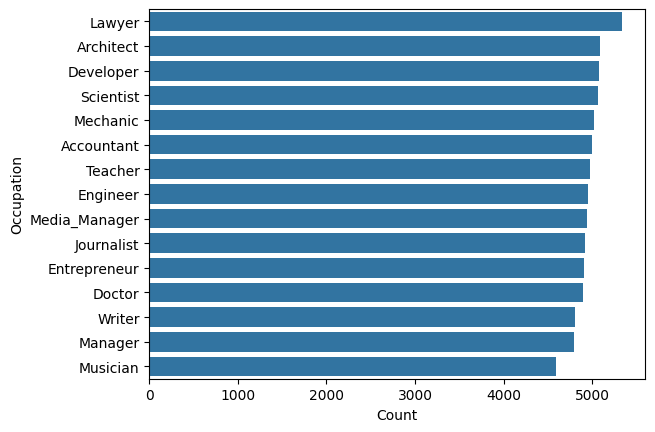

In [1021]:
occupation_count = df['Occupation'].value_counts()
sns.barplot(x = occupation_count.values, y = occupation_count.index, orient = 'h')
plt.xlabel('Count')
plt.ylabel('Occupation');

In [1022]:
df['Occupation'].isnull().sum()

np.int64(5637)

Does all the customers have same occupation or multiple throughout the 8-months period?

In [1023]:
df.groupby('Customer_ID')['Occupation'].nunique().value_counts()

Occupation
1    10000
Name: count, dtype: int64

In [1024]:
df.groupby('Customer_ID')['Occupation'].count().value_counts()

Occupation
8    5580
7    3373
6     892
5     140
4      15
Name: count, dtype: int64

So, no one has transitioned into new role or maybe its not mentioned and is coming as null. But these possibilities we obviously can't tell until and unless we get back to the customer. We need to make the most appropriate educated guess for now.

Transitioning to new role or leaving jobs in a count of 12500 customers during 8-month period is definitley possible but will be a relatively lower amount. For now, the best educated guess would be to take the same profession throughout the 8-months period. We can use forward fill and backward fill here.

In [1025]:
df['Occupation'] = df.groupby('Customer_ID')['Occupation'].transform(forward_backward_fill)

In [1026]:
df['Occupation'].isnull().sum()

np.int64(0)

#### 3. Annual Income and monthly inhand salary

Both annual income and monthly inhand salary go hand in hand and if there is some erroneous or missing value in one column then the other might have information on what might be the correct guess.

Lets look at the distribution of annual income. Right now, we don't have any null values present in this column but maybe there are extreme or erroneous values present.

In [1027]:
summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

Column description for Annual_Income:

count    8.000000e+04
mean     1.772119e+05
std      1.440363e+06
min      7.005930e+03
25%      1.937048e+04
50%      3.724022e+04
75%      7.269014e+04
max      2.419806e+07
Name: Annual_Income, dtype: float64

Number of null values: 0 




Looks like there are a lot of extreme values present, typically the annual income is definitely skewed but not by this much and these are therefore most probably present due to error while filling the data.

Lets look at some customer data to understand this better.

In [1028]:
np.random.seed(41)
df[df['Customer_ID'].isin(np.random.choice(df['Customer_ID'].unique(), 5))]

,Unnamed: 0,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
7448,49656,CUS_0x23a4,1,42,Lawyer,53876.88,4566.740000,8,7,19,...,Standard,1341.25,33.425033,NaN,Yes,168.709708,122.268859,High_spent_Medium_value_payments,415.695434,Poor
7449,49657,CUS_0x23a4,2,42,Lawyer,53876.88,4566.740000,8,7,19,...,NaN,1341.25,28.292596,19 Years and 3 Months,Yes,168.709708,409.424856,Low_spent_Small_value_payments,168.539436,Poor
7450,49658,CUS_0x23a4,3,42,Lawyer,53876.88,4566.740000,8,7,19,...,NaN,1341.25,35.995217,19 Years and 4 Months,Yes,168.709708,177.792261,Low_spent_Medium_value_payments,390.172032,Poor
7451,49659,CUS_0x23a4,4,42,Lawyer,53876.88,NaN,8,7,19,...,Standard,1341.25,37.767161,19 Years and 5 Months,NM,168.709708,199.807799,Low_spent_Small_value_payments,378.156494,Poor
7452,49660,CUS_0x23a4,5,42,Lawyer,53876.88,4566.740000,8,7,19,...,Standard,1341.25,32.310713,19 Years and 6 Months,NM,168.709708,83.756629,High_spent_Medium_value_payments,454.207663,Poor
7453,49661,CUS_0x23a4,6,42,Lawyer,53876.88,4566.740000,8,7,19,...,Standard,1341.25,34.784210,19 Years and 7 Months,Yes,168.709708,425.387629,Low_spent_Medium_value_payments,142.576663,Poor
7454,49662,CUS_0x23a4,7,42,Lawyer,53876.88,4566.740000,8,7,19,...,Standard,1341.25,31.017887,19 Years and 8 Months,Yes,168.709708,270.824140,High_spent_Small_value_payments,277.140153,Poor
7455,49663,CUS_0x23a4,8,42,Lawyer,53876.88,4566.740000,8,7,19,...,NaN,1341.25,24.002397,19 Years and 9 Months,Yes,18868.000000,221.011490,High_spent_Small_value_payments,326.952802,Poor
15872,32320,CUS_0x37db,1,17,Entrepreneur,19559.45,1665.954167,5,4,20,...,Standard,1115.06,39.902875,18 Years and 10 Months,Yes,38.287217,95.110353,High_spent_Small_value_payments,293.197847,Standard
15873,32321,CUS_0x37db,2,17,Entrepreneur,19559.45,1665.954167,5,4,20,...,Standard,1115.06,30.008105,18 Years and 11 Months,Yes,38.287217,25.741711,High_spent_Large_value_payments,342.566489,Standard


Looking at the data, looks like in some places the annual income is wrongly given as a very huge value even though the monthly inhand salary is same as other months. Also, in some places the monthly inhand salary is missing while annual income is given either same or different than some other months.

Lets look at distriubtion of monthly inhand salary now.

In [1029]:
summary_monthly_inhand_salary = summarize_numerical_column_with_deviation(df, 'Monthly_Inhand_Salary', 'Customer_ID', True, True)

Column description for Monthly_Inhand_Salary:

count    68024.000000
mean      4187.986857
std       3189.454847
min        319.556250
25%       1623.555417
50%       3068.576667
75%       5954.646667
max      15204.633333
Name: Monthly_Inhand_Salary, dtype: float64

Number of null values: 11976 




Median standardization for Monthly_Inhand_Salary:

count    68024.000000
mean         0.000098
std          0.108418
min         -2.057073
25%          0.000000
50%          0.000000
75%          0.000000
max          2.221375
Name: Monthly_Inhand_Salary, dtype: float64

Number of null values: 11976 




This indicates that monthly inhand salary is mostly same but sometimes changes, which looks normal as salary may change due to shift allowances based on months and shifts, promotions, appraisals, other type of allowances and based on varying tax deduction. But as noted earlier monthly inhand salary column has null values which need to be handled.

Since monthly inhand salary looks correct, we can use the non-null data of monthly inhand salary and group it with customer id, then fill all the annual incomes with the mode of annual income. Lets hope the data doesn't contain multiple modes for each groupy by of customer id and monthly inhand salary value, we will check that below.

In [1030]:
df.groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_num_of_modes).value_counts()

Annual_Income
1.0    68016
2.0        8
Name: count, dtype: int64

Looks like there are some monthly inhand salaries which have 2 modes, this is problematic. How do we decide which mode to use in this case? Lets look at the data as the number is relatively very low.

In [1031]:
df[df.groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_num_of_modes) == 2]

,Unnamed: 0,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
38216,5976,CUS_0x697,1,18,Musician,4866540.00,1735.450000,7,7,26,...,Bad,3724.85,34.347809,13 Years and 2 Months,Yes,58.485433,59.345795,High_spent_Medium_value_payments,305.713772,Standard
38217,5977,CUS_0x697,2,18,Musician,17993.40,1735.450000,7,7,26,...,NaN,3724.85,37.227689,13 Years and 3 Months,Yes,58.485433,74.392646,Low_spent_Large_value_payments,310.666921,Standard
39912,70272,CUS_0x6d3c,1,19,Accountant,29167.68,2138.640000,8,9,21,...,Bad,2091.98,25.569235,11 Years and 9 Months,Yes,49.619467,134.744160,Low_spent_Large_value_payments,299.500373,Poor
39913,70273,CUS_0x6d3c,2,20,Accountant,23070456.00,2138.640000,8,9,21,...,Bad,2091.98,37.993483,11 Years and 10 Months,Yes,49.619467,194.307409,Low_spent_Large_value_payments,239.937124,Poor
67622,8414,CUS_0xadc8,7,30,Mechanic,84374.12,6605.370947,8,7,9,...,Standard,1000.76,34.411201,NaN,Yes,744.037446,625.907159,Low_spent_Small_value_payments,239.278782,Standard
67623,8415,CUS_0xadc8,8,30,Mechanic,18884777.00,6605.370947,8,7,9,...,NaN,1000.76,31.424325,22 Years and 5 Months,Yes,744.037446,124.428583,High_spent_Large_value_payments,690.757357,Good
76584,10824,CUS_0xc2a4,1,49,Writer,22378557.00,10018.500000,4,3,9,...,NaN,584.61,39.991332,21 Years and 8 Months,No,128.927351,429.200991,Low_spent_Large_value_payments,713.721658,Good
76586,10826,CUS_0xc2a4,3,50,Writer,122322.00,10018.500000,4,3,9,...,Good,584.61,38.974569,21 Years and 10 Months,No,128.927351,1015.108832,Low_spent_Medium_value_payments,137.813817,Good


This double mode situation is happening for 14 records and what we can notice is that there are too extreme values which are not suitable as annual income. We can just choose the minimum mode in these cases where two modes exist for same monthly inhand salary.

In [1032]:
df['Annual_Income'][df['Monthly_Inhand_Salary'].notnull()] = df[df['Monthly_Inhand_Salary'].notnull()].groupby(['Customer_ID', 'Monthly_Inhand_Salary'], group_keys = False)['Annual_Income'].transform(return_mode)

This has handled all records for which monthly inhand salary is not null. Lets look at the distribution of Annual Income again.

In [1033]:
summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

Column description for Annual_Income:

count    8.000000e+04
mean     6.972199e+04
std      5.671541e+05
min      7.005930e+03
25%      1.929580e+04
50%      3.686268e+04
75%      7.173548e+04
max      2.388456e+07
Name: Annual_Income, dtype: float64

Number of null values: 0 




Still some values are very high but it has reduced from before. These high values should exist in records which have null as monthly inhand salary.

Now, lets take care of monthly inhand salary as well, in a similar way as annual income. We can replace null values by looking at nearby monthly inhand salary of a same annual income value for given customer. It might have happened that monthly inhand salary changed because of some tax changes even though the annual income remained same.

In [1034]:
df['Monthly_Inhand_Salary'] = df.groupby(['Customer_ID', 'Annual_Income'], group_keys = False)['Monthly_Inhand_Salary'].transform(forward_backward_fill)

In [1035]:
df['Monthly_Inhand_Salary'].isnull().sum()

np.int64(117)

Still 147 records exist which have null values in monthly inhand salary and correpsonding annual income is different from other month data. These values might probably be erroneous values. Lets look at the deviation with respect to median for these annual incomes only.

In [1036]:
Annual_Income_deviation = df.groupby('Customer_ID', group_keys = False)['Annual_Income'].apply(lambda x: (x - x.median())/x.median())

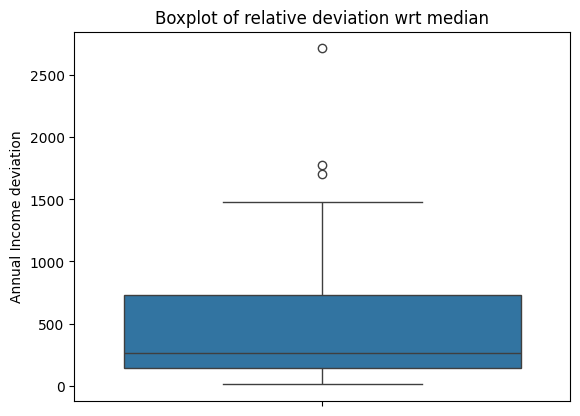

In [1037]:
temp = Annual_Income_deviation[df['Monthly_Inhand_Salary'].isnull()]
sns.boxplot(temp.values)
plt.title('Boxplot of relative deviation wrt median')
plt.ylabel('Annual Income deviation');

In [1038]:
print(temp.describe())

count     117.000000
mean      456.865500
std       452.055047
min        13.095392
25%       141.239862
50%       267.837824
75%       727.391533
max      2712.464587
Name: Annual_Income, dtype: float64


Minimum is 3 i.e. the given extreme annual incomes are around 4 times the median annual income of the customer, these all are very very rare cases and most probably are present due to error in data entry. We will remove these values and fill them by neighbour records using fills.

In [1039]:
df['Annual_Income'][df['Monthly_Inhand_Salary'].isnull()] = np.nan

Lets look at the annual income deviation to see if it is now free of outliers or not.

In [1040]:
Annual_Income_deviation = df.groupby('Customer_ID', group_keys = False)['Annual_Income'].apply(lambda x: (x - x.median())/x.median())

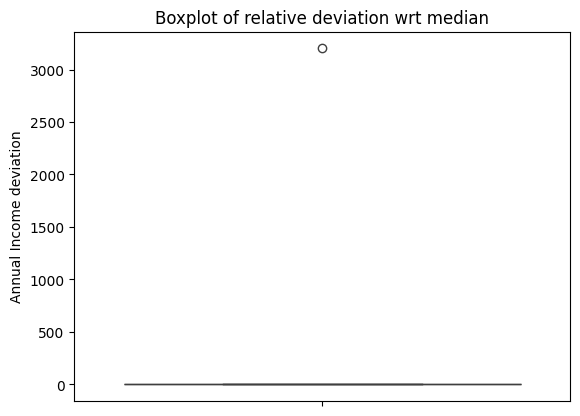

In [1041]:
sns.boxplot(Annual_Income_deviation.values)
plt.title('Boxplot of relative deviation wrt median')
plt.ylabel('Annual Income deviation');

There are still two values. Lets extract and see their customer data.

In [1042]:
Annual_Income_deviation[Annual_Income_deviation > 500]

34042    3201.76901
Name: Annual_Income, dtype: float64

In [1043]:
df.iloc[[34028]]

,Unnamed: 0,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
34028,27732,CUS_0x6075,5,19,Musician,29223.35,2611.279167,5,3,18,...,NaN,436.64,25.343923,26 Years and 8 Months,No,64.130268,304.979535,Low_spent_Small_value_payments,182.018113,Standard


In [1044]:
df[df['Customer_ID'].isin(['CUS_0x6075'])]

,Unnamed: 0,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
34024,27728,CUS_0x6075,1,19,Musician,29223.35,2611.279167,5,3,18,...,NaN,436.64,37.804486,26 Years and 4 Months,NM,64.130268,222.848131,Low_spent_Large_value_payments,244.149518,Standard
34025,27729,CUS_0x6075,2,19,Musician,29223.35,2611.279167,5,3,18,...,Standard,436.64,35.657598,26 Years and 5 Months,No,64.130268,79.783191,Low_spent_Large_value_payments,387.214458,Standard
34026,27730,CUS_0x6075,3,19,Musician,29223.35,2611.279167,5,3,18,...,Standard,436.64,35.362003,26 Years and 6 Months,No,64.130268,217.382779,Low_spent_Small_value_payments,269.614870,Standard
34027,27731,CUS_0x6075,4,19,Musician,29223.35,2611.279167,5,3,18,...,Standard,436.64,37.342998,26 Years and 7 Months,No,64.130268,98.545589,High_spent_Medium_value_payments,348.452059,Standard
34028,27732,CUS_0x6075,5,19,Musician,29223.35,2611.279167,5,3,18,...,NaN,436.64,25.343923,26 Years and 8 Months,No,64.130268,304.979535,Low_spent_Small_value_payments,182.018113,Standard
34029,27733,CUS_0x6075,6,19,Musician,29223.35,2611.279167,5,3,18,...,NaN,436.64,38.811039,26 Years and 9 Months,No,64.130268,NaN,High_spent_Medium_value_payments,354.397950,Standard
34030,27734,CUS_0x6075,7,19,Musician,29223.35,2611.279167,5,3,18,...,Standard,436.64,38.671912,NaN,No,64.130268,211.488959,Low_spent_Small_value_payments,275.508690,Standard
34031,27735,CUS_0x6075,8,19,Musician,29223.35,2611.279167,5,3,18,...,Standard,436.64,36.691142,NaN,No,64.130268,167.455467,Low_spent_Large_value_payments,299.542182,Standard


In [1045]:
df.loc[[34028], ['Annual_Income', 'Monthly_Inhand_Salary']] = np.nan

There are records which have very high annual income and monthly inhand salary is comparable but not same as other months. Rest of the data is same for other months and we can make it same after making them null.

In [1046]:
df['Annual_Income'] = df.groupby('Customer_ID')['Annual_Income'].transform(forward_backward_fill)
df['Monthly_Inhand_Salary'] = df.groupby('Customer_ID')['Monthly_Inhand_Salary'].transform(forward_backward_fill)

In [1047]:
summary_annual_income = summarize_numerical_column_with_deviation(df, 'Annual_Income', 'Customer_ID', True, False)

Column description for Annual_Income:

count    8.000000e+04
mean     5.076891e+04
std      9.101956e+04
min      7.005930e+03
25%      1.928073e+04
50%      3.682100e+04
75%      7.167600e+04
max      2.339320e+07
Name: Annual_Income, dtype: float64

Number of null values: 0 




In [1048]:
summary_monthly_inhand_salary = summarize_numerical_column_with_deviation(df, 'Monthly_Inhand_Salary', 'Customer_ID', True, False)

Column description for Monthly_Inhand_Salary:

count    80000.000000
mean      4196.339376
std       3193.986148
min        319.556250
25%       1626.525000
50%       3074.046250
75%       5957.715000
max      15204.633333
Name: Monthly_Inhand_Salary, dtype: float64

Number of null values: 0 




Both the distributions look ok now.

#### 4. Number of Bank Accounts

In [1049]:
summary_num_bank_accounts = summarize_numerical_column_with_deviation(df, 'Num_Bank_Accounts', median_standardization_summary = True)

Column description for Num_Bank_Accounts:

count    80000.000000
mean        17.062275
std        117.657776
min         -1.000000
25%          3.000000
50%          6.000000
75%          7.000000
max       1798.000000
Name: Num_Bank_Accounts, dtype: float64

Number of null values: 0 




Median standardization for Num_Bank_Accounts:

count    80000.000000
mean        11.815637
std        119.276867
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2971.000000
Name: Num_Bank_Accounts, dtype: float64

Number of null values: 0 




In [1050]:
summary_num_bank_accounts

{'Num_Bank_Accounts': {'Min. value': np.int64(-1),
  'Outlier lower range': -3.0,
  'Outlier upper range': 13.0,
  'Max. value': np.int64(1798)},
 'Median standardization of Num_Bank_Accounts': {'Min. value': np.float64(-2.0),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(2971.0)},
 'Max. MAD': np.float64(1.0)}

There are some negative values which are not possible. Lets convert them to null for now.

In [1051]:
df['Num_Bank_Accounts'][df['Num_Bank_Accounts'] < 0] = np.nan

Max. MAD value is 1, this means MAD  can take values like 0, 0.5 or 1 given the nature of data. Lets try to observe the median standardization data.

In [1052]:
df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts')).value_counts()

Num_Bank_Accounts
 0.0       78280
-1.0         345
 1.0         289
-2.0          21
 516.0         4
           ...  
 1013.0        1
 484.0         1
 977.0         1
 48.0          1
 109.0         1
Name: count, Length: 787, dtype: int64

In [1053]:
np.sort((df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts'))).unique())[:10]

array([-2., -1.,  0.,  1., 12., 20., 21., 22., 23., 27.])

The first four values look ok as median standardization should be usually small only. But after that the values look too big to be real and thus, can be changed to nulls.

In [1054]:
df['Num_Bank_Accounts'][df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Bank_Accounts')).abs() > 2] = np.nan

In [1055]:
summary_num_bank_accounts = summarize_numerical_column_with_deviation(df, 'Num_Bank_Accounts', median_standardization_summary = True)

Column description for Num_Bank_Accounts:

count    78935.000000
mean         5.365972
std          2.582345
min          0.000000
25%          3.000000
50%          6.000000
75%          7.000000
max         11.000000
Name: Num_Bank_Accounts, dtype: float64

Number of null values: 1065 




Median standardization for Num_Bank_Accounts:

count    78935.000000
mean        -0.001520
std          0.152005
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Num_Bank_Accounts, dtype: float64

Number of null values: 1065 




For the null values as an educated guess we can just take the forward and backward fills.

In [1056]:
df['Num_Bank_Accounts'] = df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(forward_backward_fill).astype(int)

What if we take one level difference at customer level? The difference can be 0, negative or positive but shouldn't be too high as the number of bank accounts shouldnt usually jump or decrease too much suddenly.

In [1057]:
df.groupby('Customer_ID')['Num_Bank_Accounts'].transform(pd.Series.diff).value_counts()

Num_Bank_Accounts
 0.0    69771
 1.0      122
-1.0      107
Name: count, dtype: int64

Mostly, the number of bank accounts remain same across months but rarely it can increase or decrease by one. This is understandable and looks ok.

In [1058]:
df.groupby('Customer_ID')['Num_Bank_Accounts'].agg(lambda x: x.diff().sum()).value_counts()

Num_Bank_Accounts
 0.0    9771
 1.0     122
-1.0     107
Name: count, dtype: int64

The number of 1 and -1 are same as above. This is only possible when all these 1 and -1 belong to different customers i.e. in 8-months period either number of bank account remains same, increases by 1 or decreases by 1 in between the months for a customer. No weird patterns exist in here.

#### 5. Number of credit cards

The same procedure as number of bank accounts can be followed for number of credit cards.

In [1059]:
summary_num_credit_cards = summarize_numerical_column_with_deviation(df, 'Num_Credit_Card', median_standardization_summary = True)

Column description for Num_Credit_Card:

count    80000.000000
mean        22.765950
std        130.612063
min          0.000000
25%          4.000000
50%          6.000000
75%          7.000000
max       1499.000000
Name: Num_Credit_Card, dtype: float64

Number of null values: 0 




Median standardization for Num_Credit_Card:

count    80000.000000
mean        34.446700
std        261.189289
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       2992.000000
Name: Num_Credit_Card, dtype: float64

Number of null values: 0 




In [1060]:
summary_num_credit_cards

{'Num_Credit_Card': {'Min. value': np.int64(0),
  'Outlier lower range': -0.5,
  'Outlier upper range': 11.5,
  'Max. value': np.int64(1499)},
 'Median standardization of Num_Credit_Card': {'Min. value': np.float64(-2.0),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(2992.0)},
 'Max. MAD': np.float64(0.5)}

Max. MAD value is 1, this means MAD  can take values like 0, 0.5 or 1 given the nature of data. Lets try to observe the median standardization data.

In [1061]:
df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card')).value_counts()

Num_Credit_Card
 0.0       77520
-2.0         239
 2.0         156
-1.0         136
 1.0         130
           ...  
 2895.0        1
 478.0         1
 2852.0        1
 1608.0        1
 2118.0        1
Name: count, Length: 1050, dtype: int64

In [1062]:
np.sort((df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card'))).unique())[:10]

array([-2., -1.,  0.,  1.,  2., 12., 16., 20., 22., 28.])

The first four values look ok as median standardization should be usually small only. But after that the values look too big to be real and thus, can be changed to nulls.

In [1063]:
df['Num_Credit_Card'][df.groupby('Customer_ID')['Num_Credit_Card'].transform(median_standardization, default_value = return_max_MAD(df, 'Num_Credit_Card')).abs() > 2] = np.nan

In [1064]:
summary_num_credit_cards = summarize_numerical_column_with_deviation(df, 'Num_Credit_Card', median_standardization_summary = True)

Column description for Num_Credit_Card:

count    78181.000000
mean         5.541372
std          2.063055
min          0.000000
25%          4.000000
50%          5.000000
75%          7.000000
max         11.000000
Name: Num_Credit_Card, dtype: float64

Number of null values: 1819 




Median standardization for Num_Credit_Card:

count    78181.000000
mean        -0.001765
std          0.154565
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: Num_Credit_Card, dtype: float64

Number of null values: 1819 




For the null values as an educated guess we can just take the forward and backward fills.

In [1065]:
df['Num_Credit_Card'] = df.groupby('Customer_ID')['Num_Credit_Card'].transform(forward_backward_fill).astype(int)

What if we take one level difference at customer level? The difference can be 0, negative or positive but shouldn't be too high as the number of bank accountscredit cards shouldnt usually jump or decrease too much suddenly.

In [1066]:
df.groupby('Customer_ID')['Num_Credit_Card'].transform(pd.Series.diff).value_counts()

Num_Credit_Card
 0.0    69766
 1.0      123
-1.0      111
Name: count, dtype: int64

Mostly, the number of credit cards remain same across months but rarely it can increase or decrease by one. This is understandable and looks ok.

In [1067]:
df.groupby('Customer_ID')['Num_Credit_Card'].agg(lambda x: x.diff().sum()).value_counts()

Num_Credit_Card
 0.0    9766
 1.0     123
-1.0     111
Name: count, dtype: int64

The number of 1 and -1 are same as above. This is only possible when all these 1 and -1 belong to different customers i.e. in 8-months period either number of bank account remains same, increases by 1 or decreases by 1 in between somewhere. No weird patterns exist in there.

#### 6. Interest Rate

In [1068]:
summary_interest_rate = summarize_numerical_column_with_deviation(df, 'Interest_Rate', median_standardization_summary = True)

Column description for Interest_Rate:

count    80000.000000
mean        71.971700
std        463.809393
min          1.000000
25%          8.000000
50%         14.000000
75%         20.000000
max       5797.000000
Name: Interest_Rate, dtype: float64

Number of null values: 0 




Median standardization for Interest_Rate:

count    69400.0
mean         inf
std          NaN
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          inf
Name: Interest_Rate, dtype: float64

Number of null values: 10600 




In [1069]:
summary_interest_rate

{'Interest_Rate': {'Min. value': np.int64(1),
  'Outlier lower range': -10.0,
  'Outlier upper range': 38.0,
  'Max. value': np.int64(5797)},
 'Median standardization of Interest_Rate': {'Min. value': np.float64(0.0),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(inf)},
 'Max. MAD': np.float64(0.0)}

In [1070]:
df.groupby('Customer_ID')['Interest_Rate'].nunique().value_counts()

Interest_Rate
1    8472
2    1435
3      90
4       3
Name: count, dtype: int64

What we observe is MAD is 0(since max. MAD is 0) for each customer. Thus, it is hard to look at median standardization and assess points using this. Lets try to look at deviation from median. Since interest rate is not a feature whose median should deviate too much in scale from customer to customer.

In [1071]:
deviation_from_median = df.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: (x - x.median()))

In [1072]:
deviation_from_median.describe()

count    80000.000000
mean        57.411600
std        463.717505
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       5788.000000
Name: Interest_Rate, dtype: float64

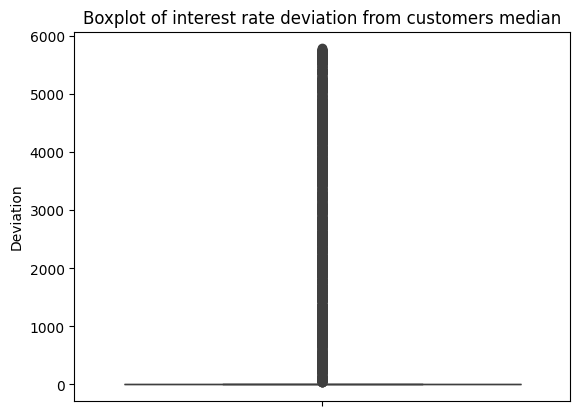

In [1073]:
sns.boxplot(deviation_from_median)
plt.title('Boxplot of interest rate deviation from customers median')
plt.ylabel('Deviation');

In [1074]:
deviation_from_median.value_counts()

Interest_Rate
0.0       78376
3548.0        3
2853.0        3
1880.0        3
906.0         3
          ...  
5756.0        1
2710.0        1
3496.0        1
3468.0        1
369.0         1
Name: count, Length: 1409, dtype: int64

In [1075]:
np.sort(deviation_from_median.unique())

array([   0.,   37.,   41., ..., 5778., 5780., 5788.])

Looking at the above data indicates that either interest rate is same as median or varies by at least 37% difference or more which is almost never seen in real life. We will fill all the records of customer with customer's median.

In [1076]:
df['Interest_Rate'] = df.groupby('Customer_ID')['Interest_Rate'].transform(lambda x: x.median())

#### 7. Number of loans

In [1077]:
summary_num_of_loans = summarize_numerical_column_with_deviation(df, 'Num_of_Loan')

Column description for Num_of_Loan:

count    80000.000000
mean         3.111512
std         63.460074
min       -100.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1496.000000
Name: Num_of_Loan, dtype: float64

Number of null values: 0 




There are clearly some outliers as the number of loans can't be these many.

The type of loans column can be used to extract this information accurately as the loans taken, their order and the count is embedded inside type of loan column.

In [1078]:
df['Type_of_Loan'].isnull().sum()

np.int64(9016)

There are 11408 null values inside type of loan column which were added by us after replacing the placeholder. Maybe these represent no loans. Lets extract the loans count from type of loan column and fill it in num of loans column.

In [1079]:
num_of_loans = df['Type_of_Loan'].str.split(', ').str.len()

In [1080]:
df['Num_of_Loan'][num_of_loans.notnull()] = num_of_loans[num_of_loans.notnull()]

We have changed the values of number of loans columns for which we had valid data from type of loan column. Lets look at the values in number of loans column which were not touched.

In [1081]:
df['Num_of_Loan'][num_of_loans.isnull()].value_counts()

Num_of_Loan
 0       8638
-100      331
 911        2
 193        1
 995        1
 1447       1
 621        1
 1296       1
 238        1
 33         1
 439        1
 252        1
 1035       1
 372        1
 143        1
 103        1
 652        1
 1416       1
 999        1
 1451       1
 501        1
 654        1
 773        1
 437        1
 336        1
 288        1
 1227       1
 153        1
 1369       1
 1444       1
 831        1
 1384       1
 394        1
 330        1
 1419       1
 859        1
 378        1
 1430       1
 126        1
 50         1
 940        1
 1382       1
 538        1
 172        1
 1347       1
 881        1
 1074       1
 1070       1
Name: count, dtype: int64

In [1082]:
np.sort(df['Num_of_Loan'][num_of_loans.isnull()].value_counts().index)

array([-100,    0,   33,   50,  103,  126,  143,  153,  172,  193,  238,
        252,  288,  330,  336,  372,  378,  394,  437,  439,  501,  538,
        621,  652,  654,  773,  831,  859,  881,  911,  940,  995,  999,
       1035, 1070, 1074, 1227, 1296, 1347, 1369, 1382, 1384, 1416, 1419,
       1430, 1444, 1447, 1451])

Mostly these are 0 which represent no loans. Other than this there are either negative values or too high values to be representing real count for number of loans. Looking at the data, we can assume here that all these are erroneous values and should actually be 0 i.e. specifying no loans.

In [1083]:
df['Num_of_Loan'][num_of_loans.isnull()] = 0

In [1084]:
df['Num_of_Loan'] = df.groupby('Customer_ID')['Num_of_Loan'].transform(forward_backward_fill).astype(int)

What if we take one level difference at customer level? The difference can be 0, negative or positive but shouldn't be too high.

In [1085]:
df.groupby('Customer_ID')['Num_of_Loan'].transform(pd.Series.diff).value_counts()

Num_of_Loan
0.0    70000
Name: count, dtype: int64

This means that number of loans remain same throughout the 8-months period for each customer.

#### 8. Type of loan

In [1086]:
df['Type_of_Loan'].value_counts()

Type_of_Loan
Not Specified                                                                                                                                                         1104
Personal Loan                                                                                                                                                         1016
Credit-Builder Loan                                                                                                                                                   1016
Debt Consolidation Loan                                                                                                                                               1000
Mortgage Loan                                                                                                                                                          960
                                                                                                                                    

Here we see that the placeholder 'Not Specified' has been used as a way of indicating that the type of loan has not been specified by the customer. 

In [1087]:
df['Type_of_Loan'].nunique()

5214

In [1088]:
df['Type_of_Loan'].isnull().sum()

np.int64(9016)

Total 11408 null values. As noted earlier with number of loans these most probably represent no loans.

We can replace the same with our own placeholder for that - 'No Loan'.

In [1089]:
df['Type_of_Loan'].fillna('No Loan', inplace = True)

Lets seen what and how many unique type of loans we have.

In [1090]:
temp_series = df['Type_of_Loan']

In [1091]:
temp_lengths = temp_series.str.split(', ').str.len().astype(int) # Number of loans

In [1092]:
temp_lengths_max = temp_lengths.max()

In [1093]:
for index, val in temp_lengths.items():
    temp_series[index] = (temp_lengths_max - val) * 'No Loan, ' + temp_series[index]

In [1094]:
temp_series.head()

0    No Loan, No Loan, No Loan, No Loan, No Loan, N...
1    No Loan, No Loan, No Loan, No Loan, No Loan, N...
2    No Loan, No Loan, No Loan, No Loan, No Loan, N...
3    No Loan, No Loan, No Loan, No Loan, No Loan, N...
4    No Loan, No Loan, No Loan, No Loan, No Loan, N...
Name: Type_of_Loan, dtype: object

In [1095]:
temp = temp_series.str.split(pat = ', ', expand = True)
unique_loans = set()
for col in temp.columns:
    temp[col] = temp[col].str.lstrip('and ')
    unique_loans.update(temp[col].unique())
print(unique_loans)

{'Student Loan', 'Personal Loan', 'Debt Consolidation Loan', 'Home Equity Loan', 'Not Specified', 'Auto Loan', 'Payday Loan', 'Mortgage Loan', 'Credit-Builder Loan', 'No Loan'}


In [1096]:
len(unique_loans)

10

There are total 8 unique type of loans, one placeholder for no specification of loan type and one placeholder added by us to specify there is no loan.

When we are working with tree based models usually they don't need the categorical columns to be encoded to numerical data type like we need for linear regression, logistic regression etc. as the model can handle these. But scikit learn uses CART algorithm and there is no functionality of using categorical variables directly and thus, for modelling with scikit-learn they need to be numerically encoded. Right now in this column we have 6260 unique categories which is too much to search for at one node. as at each node, a decision tree will look at all possible values of the categorical column to figure out what value produces the best split based on gini impurity or entropy decrease on splitting. We can do some pre-prcoessing on this column to split it into multiple columns. Intutively, it feels like the lastest loan should have high influence on your credit score because if the loan is heavy in nature then it might lead to poor credit score if unable to pay while if it is light then the credit score should remain almost same as before. We can split the column in following format: Latest loan1, latest loan2 etc. This way we will have 9 columns corresponding to maximum number of loans for any customer and each column can have maximum 10 categorical values corresponding to the unqiue loans calculated above. 

This approach will have following benefits:  
1. Preserves the order of loans even after splitting.
2. Easier to visualize and understand patterns since number of categories per column reduces.    
3. Algorithm can focus more on information contained within the loan sequence. For example, if second last and third last loan contain critical information in classifying credit score than focussing on whole sequence of loans is not worthwhile and this inturn might lead to smaller decision trees and faster training compared to if we didn't split.  
4. At each node for 9 of the splitted columns only total 90(9 columns * 10 categories) comparisons need to be made after one-hot encoding rather than 6260 comparisons for one non-splitted column.

Another possible approach could be to split columns as first loan, second loan etc. as a way of splitting but the pre-processing mentioned above feels more effective for now. We will maybe look at these two modeling startegies whn we do EDA and modeling.

In [1097]:
temp.columns = [f'Last_Loan_{i}' for i in range(int(df['Num_of_Loan'].max()), 0, -1)]

In [1098]:
temp.head()

,Last_Loan_9,Last_Loan_8,Last_Loan_7,Last_Loan_6,Last_Loan_5,Last_Loan_4,Last_Loan_3,Last_Loan_2,Last_Loan_1
0,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
1,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
2,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
3,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
4,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan


In [1099]:
df = pd.merge(df, temp, left_index = True, right_index = True)

In [1100]:
df.head()

,Unnamed: 0,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Score,Last_Loan_9,Last_Loan_8,Last_Loan_7,Last_Loan_6,Last_Loan_5,Last_Loan_4,Last_Loan_3,Last_Loan_2,Last_Loan_1
0,56752,CUS_0x1000,1,17,Lawyer,30625.94,2706.161667,6,5,27.0,...,Standard,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
1,56753,CUS_0x1000,2,17,Lawyer,30625.94,2706.161667,6,5,27.0,...,Poor,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
2,56754,CUS_0x1000,3,17,Lawyer,30625.94,2706.161667,6,5,27.0,...,Poor,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
3,56755,CUS_0x1000,4,17,Lawyer,30625.94,2706.161667,6,5,27.0,...,Poor,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan
4,56756,CUS_0x1000,5,17,Lawyer,30625.94,2706.161667,6,5,27.0,...,Poor,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,No Loan,Credit-Builder Loan,Home Equity Loan


We can drop the type of loan column from dataset.

In [1101]:
df.drop(columns = 'Type_of_Loan', inplace = True)

#### 9. Delay from due date

In [1102]:
summary_due_date = summarize_numerical_column_with_deviation(df, 'Delay_from_due_date', median_standardization_summary = True)

Column description for Delay_from_due_date:

count    80000.000000
mean        21.104625
std         14.875335
min         -5.000000
25%         10.000000
50%         18.000000
75%         28.000000
max         67.000000
Name: Delay_from_due_date, dtype: float64

Number of null values: 0 




Median standardization for Delay_from_due_date:

count    80000.000000
mean         0.000605
std          1.307092
min        -10.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: Delay_from_due_date, dtype: float64

Number of null values: 0 




In [1103]:
summary_due_date

{'Delay_from_due_date': {'Min. value': np.int64(-5),
  'Outlier lower range': -17.0,
  'Outlier upper range': 55.0,
  'Max. value': np.int64(67)},
 'Median standardization of Delay_from_due_date': {'Min. value': np.float64(-10.0),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(11.0)},
 'Max. MAD': np.float64(4.0)}

The median standardization varies quite a bit going from -10 to 11. 

In [1104]:
due_date_deviation = df.groupby('Customer_ID')['Delay_from_due_date'].transform(median_standardization, default_value = return_max_MAD(df, 'Delay_from_due_date'))

Looking at the fact that overall distribution of delay from due date is not too extreme and delay from due date can vary a lot as well unlike number of credit cards or number of bank accounts. We will move forward with the data as it is. Having a domain expert by your side would have helped make this more clearer.

#### 10. Number of delayed payments

In [1105]:
summary_num_delayed_payments = summarize_numerical_column_with_deviation(df, 'Num_of_Delayed_Payment', median_standardization_summary = True)

Column description for Num_of_Delayed_Payment:

count    74456.000000
mean        30.458298
std        222.114889
min         -3.000000
25%          9.000000
50%         14.000000
75%         18.000000
max       4397.000000
Name: Num_of_Delayed_Payment, dtype: float64

Number of null values: 5544 




Median standardization for Num_of_Delayed_Payment:

count    74456.000000
mean        11.110887
std        183.266893
min         -8.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       8388.000000
Name: Num_of_Delayed_Payment, dtype: float64

Number of null values: 5544 




In [1106]:
summary_num_delayed_payments

{'Num_of_Delayed_Payment': {'Min. value': np.float64(-3.0),
  'Outlier lower range': -4.5,
  'Outlier upper range': 31.5,
  'Max. value': np.float64(4397.0)},
 'Median standardization of Num_of_Delayed_Payment': {'Min. value': np.float64(-8.0),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(8388.0)},
 'Max. MAD': np.float64(3.0)}

Judging from median standardization, almost all of the values are same as median and this is leading to 0 median standardization. Median standardization should definitely should be like this and should be skewed in nature but its hard to assess what threshold to use without a domain expert. We will use the full column as a sample and judge based on that here.

The number of delayed payments can't be too much and can not be negative as well. We will set negative values and values greater than upper range of oultiers to null.

In [1107]:
df['Num_of_Delayed_Payment'][(df['Num_of_Delayed_Payment'] > summary_num_delayed_payments['Num_of_Delayed_Payment']['Outlier upper range']) | (df['Num_of_Delayed_Payment'] < 0)] = np.nan

In [1108]:
df['Num_of_Delayed_Payment'].isnull().sum()

np.int64(6645)

There are 8382 null values. Lets observe the count of diff in between consecutive months and observe if we can identify some pattern exising there which can help us make some educated guess about the null values.

In [1109]:
df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(pd.Series.diff).value_counts(normalize = True)

Num_of_Delayed_Payment
 0.0    0.457106
-1.0    0.085992
 2.0    0.085550
 1.0    0.085347
-2.0    0.084379
-3.0    0.082274
 3.0    0.081696
-4.0    0.009558
 4.0    0.009270
 5.0    0.006536
-5.0    0.005959
-6.0    0.003175
 6.0    0.003158
Name: proportion, dtype: float64

Around 45.6% of time it remains same across months but rest of the time it varies i.e more than 50% of the time it varies across months.

In [1110]:
df[['Customer_ID', 'Num_of_Delayed_Payment']].head(40)

,Customer_ID,Num_of_Delayed_Payment
0,CUS_0x1000,25.0
1,CUS_0x1000,23.0
2,CUS_0x1000,28.0
3,CUS_0x1000,25.0
4,CUS_0x1000,25.0
5,CUS_0x1000,23.0
6,CUS_0x1000,25.0
7,CUS_0x1000,26.0
8,CUS_0x1009,NaN
9,CUS_0x1009,16.0


Looking at the data it looks like usually a single value repeats more often across months i.e. mode might be a suitable choice here. But first lets see that usually how many times the mode occurs for any customer.

In [1111]:
# Ratio of frequency of mode and number of non-null data per customer
temp = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(lambda x: (x == x.mode()[0]).sum()/x.notnull().sum()).value_counts(normalize = True)

In [1112]:
temp[temp.index > 0.5].sum() # Idenitfying how many times the mode occurs in more than 50% of non-null data per customer

np.float64(0.7575000000000001)

That is within given data for around 75.8% of the customers the mode occurs more than 50% of the time within 8-months period for whatever data we have available. This means the mode might be a suitable imputation here.

What if there are multiple modes per customer? Lets check the data if such thing exists.

In [1113]:
df.groupby('Customer_ID')['Num_of_Delayed_Payment'].agg(lambda x: len(x.mode())).value_counts()

Num_of_Delayed_Payment
1    9620
2     292
3      77
6       5
5       3
4       3
Name: count, dtype: int64

Mostly, we observe one mode but sometimes it can be more than one as well. What to do in multiple modes case? We can take some average or median of modes in that case, in case there is skewness within the modes, median would be a better guess and in case where medians come out to be floating point number we can just take the integer part as an approximation.

In [1114]:
df['Num_of_Delayed_Payment'] = df.groupby('Customer_ID')['Num_of_Delayed_Payment'].transform(return_mode_median_filled_int).astype(int)

Number of delayed payments is something that can vary from month to month its not like it has monotically increasing pattern or so which we can use as a sanity check. What we can try to observe is the relative devaition from median for this cleaned column.

In [1115]:
summarize_numerical_column_with_deviation(df, 'Num_of_Delayed_Payment', median_standardization_summary = True)

Column description for Num_of_Delayed_Payment:

count    80000.000000
mean        13.333825
std          6.266640
min          0.000000
25%          9.000000
50%         14.000000
75%         18.000000
max         28.000000
Name: Num_of_Delayed_Payment, dtype: float64

Number of null values: 0 




Median standardization for Num_of_Delayed_Payment:

count    80000.000000
mean         0.010526
std          1.163537
min        -10.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          8.000000
Name: Num_of_Delayed_Payment, dtype: float64

Number of null values: 0 




{'Num_of_Delayed_Payment': {'Min. value': np.int64(0),
  'Outlier lower range': -4.5,
  'Outlier upper range': 31.5,
  'Max. value': np.int64(28)},
 'Median standardization of Num_of_Delayed_Payment': {'Min. value': np.float64(-10.0),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(8.0)},
 'Max. MAD': np.float64(2.5)}

#### 11. Changed credit limit

In [1116]:
summary_changed_credit_limit = summarize_numerical_column_with_deviation(df, 'Changed_Credit_Limit', median_standardization_summary = True)

Column description for Changed_Credit_Limit:

count    78330.000000
mean        10.355606
std          6.784688
min         -6.490000
25%          5.280000
50%          9.370000
75%         14.870000
max         36.970000
Name: Changed_Credit_Limit, dtype: float64

Number of null values: 1670 




Median standardization for Changed_Credit_Limit:

count    78330.000000
mean        -0.001555
std          0.863465
min        -14.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         14.000000
Name: Changed_Credit_Limit, dtype: float64

Number of null values: 1670 




Credit card limit is dependent upon the users usage patterns. If the lender trusts the customer then it can increase also and if customer is late on payments, low activity etc. then the credit lmit can decrease as well. Thus, both negative and positive values are understandable.

The upper range for outliers for full column doesn't significantly deviate from the max value and its difficult to judge here what threshold should be placed on credit limit median standardization. Thus, we leave non-null values as it is for now.

In [1117]:
df[['Customer_ID', 'Changed_Credit_Limit']].head(40)

,Customer_ID,Changed_Credit_Limit
0,CUS_0x1000,1.63
1,CUS_0x1000,1.63
2,CUS_0x1000,1.63
3,CUS_0x1000,1.63
4,CUS_0x1000,2.63
5,CUS_0x1000,1.63
6,CUS_0x1000,2.63
7,CUS_0x1000,1.63
8,CUS_0x1009,9.73
9,CUS_0x1009,9.73


Looking at the data usually the credit limit occurs with the same value across months i.e. the mode might be an appropriate value to imputate. Lets do some checks first though.

In [1118]:
df.groupby('Customer_ID')['Changed_Credit_Limit'].agg(lambda x: len(x.mode())).value_counts()

Changed_Credit_Limit
1    9992
2       8
Name: count, dtype: int64

Almost all the time only one mode appears. But sometimes two mode can occur as well, since this is a floating point type feature and there are only two mode values we will choose average of both which will be same as median in this case.

In [1119]:
df['Changed_Credit_Limit'] = df.groupby('Customer_ID')['Changed_Credit_Limit'].transform(return_mode_average_filled)

In [1120]:
df['Changed_Credit_Limit'].isnull().sum()

np.int64(0)

#### 12. Number of credit card inquiries

In [1121]:
summary_num_credit_inquiries = summarize_numerical_column_with_deviation(df, 'Num_Credit_Inquiries', median_standardization_summary = True)

Column description for Num_Credit_Inquiries:

count    78448.000000
mean        27.365949
std        190.354604
min          0.000000
25%          3.000000
50%          6.000000
75%          9.000000
max       2597.000000
Name: Num_Credit_Inquiries, dtype: float64

Number of null values: 1552 




Median standardization for Num_Credit_Inquiries:

count    78448.000000
mean         6.996741
std         93.884334
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       5070.000000
Name: Num_Credit_Inquiries, dtype: float64

Number of null values: 1552 




Judging from median standardization almost all of the values are same as median and this is leading to 0 median standardization. median standardization definitely should be like this and should be skewed in nature but its hard to assess what threshold to use without a domain expert. We will use the full column as a sample and judge based on that here.

Number of credit card inquiries cant be negative and can't be too extreme as well. We will replace those values with null for now.

In [1122]:
df['Num_Credit_Inquiries'][(df['Num_Credit_Inquiries'] > summary_num_credit_inquiries['Num_Credit_Inquiries']['Outlier upper range']) | (df['Num_Credit_Inquiries'] < 0)] = np.nan

In [1123]:
df['Num_Credit_Inquiries'].isnull().sum()

np.int64(2859)

Lets look at some data.

In [1124]:
df[['Customer_ID', 'Num_Credit_Inquiries']].head(40)

,Customer_ID,Num_Credit_Inquiries
0,CUS_0x1000,10.0
1,CUS_0x1000,11.0
2,CUS_0x1000,11.0
3,CUS_0x1000,11.0
4,CUS_0x1000,11.0
5,CUS_0x1000,11.0
6,CUS_0x1000,11.0
7,CUS_0x1000,11.0
8,CUS_0x1009,2.0
9,CUS_0x1009,2.0


This a type of data which is monotically increasing in nature and thus should increase or remain same as months go on. Lets check that.

In [1125]:
df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(pd.Series.diff).value_counts()

Num_Credit_Inquiries
0.0    59703
3.0     1089
4.0     1072
2.0     1068
1.0     1059
5.0     1050
Name: count, dtype: int64

As expected it mostly either remains same or increases. In this case we can just use forward fill and backward fill to fill these nulls.

In [1126]:
df['Num_Credit_Inquiries'] = df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(forward_backward_fill).astype(int)

Lets do the check again.

In [1127]:
df.groupby('Customer_ID')['Num_Credit_Inquiries'].transform(pd.Series.diff).value_counts()

Num_Credit_Inquiries
0.0    64335
3.0     1160
4.0     1148
2.0     1138
1.0     1113
5.0     1106
Name: count, dtype: int64

#### 13. Credit Mix

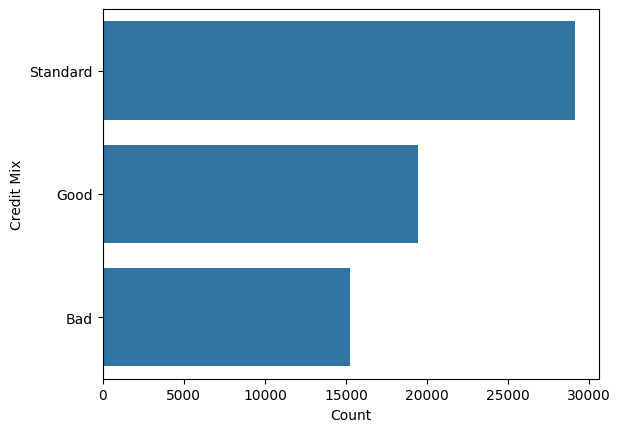

In [1128]:
credit_mix_count = df['Credit_Mix'].value_counts()
sns.barplot(x = credit_mix_count.values, y = credit_mix_count.index, orient = 'h')
plt.xlabel('Count')
plt.ylabel('Credit Mix');

In [1129]:
df['Credit_Mix'].isnull().sum()

np.int64(16149)

A lot of null values present. We have already seen that during the 8-months period the type of loans and number of loans remain same so its fair to assume credit mix will also remain same. Lets check that with the given data.

In [1130]:
df.groupby('Customer_ID')['Credit_Mix'].nunique().value_counts()

Credit_Mix
1    10000
Name: count, dtype: int64

We can observe that one customer has only one type of credit mix only, throughout the 8-months period apart from null values. We can just use forward fill and bacward fill to achieve the desired goal.

In [1131]:
df['Credit_Mix'] = df.groupby('Customer_ID')['Credit_Mix'].transform(forward_backward_fill)

In [1132]:
df['Credit_Mix'].isnull().sum()

np.int64(0)

#### 14. Outstanding debt

In [1133]:
summary_outstanding_debt = summarize_numerical_column_with_deviation(df, 'Outstanding_Debt', median_standardization_summary = True)

Column description for Outstanding_Debt:

count    80000.000000
mean      1427.878089
std       1156.913930
min          0.540000
25%        563.100000
50%       1167.045000
75%       1953.232500
max       4998.070000
Name: Outstanding_Debt, dtype: float64

Number of null values: 0 




Median standardization for Outstanding_Debt:

count    80000.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: Outstanding_Debt, dtype: float64

Number of null values: 0 




All the values in median standardization are coming out to be zero. Is the outstanding debt constant for each customer across months after ignoring nulls?

In [1134]:
df.groupby('Customer_ID')['Outstanding_Debt'].nunique().value_counts()

Outstanding_Debt
1    10000
Name: count, dtype: int64

The column looks ok from the distribution perspective and there are no nulls present.

#### 15. Credit Utilization ratio

In [1135]:
summary_credit_utilization_ratio = summarize_numerical_column_with_deviation(df, 'Credit_Utilization_Ratio', median_standardization_summary = True)

Column description for Credit_Utilization_Ratio:

count    80000.000000
mean        32.303583
std          5.120211
min         20.000000
25%         28.063496
50%         32.343787
75%         36.515261
max         50.000000
Name: Credit_Utilization_Ratio, dtype: float64

Number of null values: 0 




Median standardization for Credit_Utilization_Ratio:

count    80000.000000
mean        -0.010099
std          1.807701
min        -36.320704
25%         -1.000333
50%          0.000000
75%          0.999622
max         35.354918
Name: Credit_Utilization_Ratio, dtype: float64

Number of null values: 0 




Judging from both the graphs its hard to put a threshold on median standardization of credit utilization ratio without a domin expert and also, the distribution of the column as a whole looks decent enough to not touch it further.

#### 16. Credit History Age

In [1136]:
df[['Customer_ID', 'Credit_History_Age']].head(40)

,Customer_ID,Credit_History_Age
0,CUS_0x1000,10 Years and 2 Months
1,CUS_0x1000,10 Years and 3 Months
2,CUS_0x1000,10 Years and 4 Months
3,CUS_0x1000,10 Years and 5 Months
4,CUS_0x1000,10 Years and 6 Months
5,CUS_0x1000,10 Years and 7 Months
6,CUS_0x1000,10 Years and 8 Months
7,CUS_0x1000,10 Years and 9 Months
8,CUS_0x1009,30 Years and 5 Months
9,CUS_0x1009,30 Years and 6 Months


In [1137]:
df['Credit_History_Age'].isnull().sum()

np.int64(7245)

There are 9030 null values. Looking at the data it is of the format - '{Year} Years and {Months} Months'. Using str functions of pandas series, we can extract these two data values i.e. year and months. We will then combine them in a single column as total months because both the year data and month data can be easily extracted from total months so there will be no loss of information and we will be able to reduce one feature from our dataset.

In [1138]:
df[['Years', 'Months']] = df['Credit_History_Age'].str.extract('(?P<Years>\d+) Years and (?P<Months>\d+) Months').astype(float)

In [1139]:
df[['Years', 'Months']].describe()

,Years,Months
count,72755.000000,72755.000000
mean,17.938657,5.592124
std,8.327991,3.451794
min,0.000000,0.000000
25%,12.000000,3.000000
50%,18.000000,5.000000
75%,25.000000,9.000000
max,33.000000,11.000000


The ranges of both years and months look ok. We can proceed forward to combining them.

In [1140]:
df['Credit_History_Age'] = df['Years'] * 12 + df['Months']

In [1141]:
df.drop(columns = ['Years', 'Months'], inplace = True)

Now, we need to handle the null values.

In [1142]:
df['Credit_History_Age'].isnull().sum()

np.int64(7245)

Credit history age is simply the numbr of months that the customer has been a customer and will just keep on increasing by one each month and thus, that logic can be used to fill the required data.

In [1143]:
df['Credit_History_Age'] = df.groupby('Customer_ID')['Credit_History_Age'].transform(fill_month_history).astype(int)

#### 17. Payment of minimum amount

In [1144]:
df['Payment_of_Min_Amount'].value_counts()

Payment_of_Min_Amount
Yes    42041
No     28350
NM      9609
Name: count, dtype: int64

NM most probably means here that its not mentioned but in actual this is binary and it can contain either yes or no only. Lets see the data and figure out if we can replace it suitably with other values. First, lets check if each customer has same value for payment of minimum amount or it can vary across months.

In [1145]:
df.groupby(['Customer_ID'])['Payment_of_Min_Amount'].nunique().value_counts()

Payment_of_Min_Amount
2    6392
1    3608
Name: count, dtype: int64

There can be two possibilities here: one by replacing NM with mode of yes and no i.e. a customer is more likely to repeat his general behaviour or we can do forward fill and backward fill which would mean that current months decision is dependent upon previous month. Lets try to observe which is more probable.

First, we wil replace yes and no with 1 and 0 for sake of simplicity and NM with null.

In [1146]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({'Yes': 1, 'No': 0, 'NM': np.nan})

Lets take difference across periods and observe.

In [1147]:
df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(pd.Series.diff).value_counts()

Payment_of_Min_Amount
0.0    54131
Name: count, dtype: int64

This means either the value is same(with some nulls in between) throughout 8-months period for the customer or null occurs extactly at the transition from one value to another. So, if all values are same for a customer then we can fill the same otherwise null needs to be filled on transition and then we can fill with mode as the most probable option.

In [1148]:
df['Payment_of_Min_Amount'] = df.groupby('Customer_ID')['Payment_of_Min_Amount'].transform(lambda x: x.fillna(x.mode()[0]))

In [1149]:
df['Payment_of_Min_Amount'].isnull().sum()

np.int64(0)

In [1150]:
df['Payment_of_Min_Amount'] = df['Payment_of_Min_Amount'].map({1: 'Yes', 0: 'No'})

#### 18. Total EMI per month

In [1151]:
summary_total_emi_per_month = summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)

Column description for Total_EMI_per_month:

count    80000.000000
mean      1394.439185
std       8280.100772
min          0.000000
25%         30.645027
50%         69.318868
75%        160.539300
max      82256.000000
Name: Total_EMI_per_month, dtype: float64

Number of null values: 0 




Median standardization for Total_EMI_per_month:

count    80000.000000
mean         1.586283
std        193.086318
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      42676.281086
Name: Total_EMI_per_month, dtype: float64

Number of null values: 0 




In [1152]:
summary_total_emi_per_month

{'Total_EMI_per_month': {'Min. value': np.float64(0.0),
  'Outlier lower range': -164.19638214496305,
  'Outlier upper range': 355.380709554532,
  'Max. value': np.float64(82256.0)},
 'Median standardization of Total_EMI_per_month': {'Min. value': np.float64(-2.0),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(42676.28108613688)},
 'Max. MAD': np.float64(21539.882895841736)}

Looking at the median standardization, few points look out of the ordinary where relative deviation is greater than 10000. Having such high deviation is obviously very unlikely, we will first discard these few points.

In [1153]:
deviation_total_emi = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(median_standardization, default_value = return_max_MAD(df, 'Total_EMI_per_month'))

In [1154]:
df['Total_EMI_per_month'][deviation_total_emi > 10000] = np.nan

In [1155]:
summary_total_emi_per_month = summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)

Column description for Total_EMI_per_month:

count    79998.000000
mean      1393.039261
std       8275.386029
min          0.000000
25%         30.645027
50%         69.318349
75%        160.539300
max      82256.000000
Name: Total_EMI_per_month, dtype: float64

Number of null values: 2 




Median standardization for Total_EMI_per_month:

count    79998.000000
mean         0.641878
std         31.675408
min         -2.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       4083.063565
Name: Total_EMI_per_month, dtype: float64

Number of null values: 2 




Its hard to quantify a threshold on median standardization without domain expertise and thats why we will use the whole column as a whole for further analysis.

Using the whole column we will replace values more than upper range of outliers with null for now.

In [1156]:
df['Total_EMI_per_month'][(df['Total_EMI_per_month'] > summary_total_emi_per_month['Total_EMI_per_month']['Outlier upper range'])] = np.nan

In [1157]:
df['Total_EMI_per_month'].isnull().sum()

np.int64(5491)

There are 6795 null values now.

Lets check how many unique values of EMI exist per customer.

In [1158]:
df.groupby('Customer_ID')['Total_EMI_per_month'].nunique().value_counts()

Total_EMI_per_month
1    9422
2     330
0     248
Name: count, dtype: int64

There are 297 customers which don't have any EMI data at all. This is around 2.3% of the data. What does this mean? That 8-months period emi data is missing now but earlier the whole column did not have any null values at all then how did full 8-month data disappear for 297 customers? Since we did outlier detection by considering whole column as our sample maybe some emi's are real but still too high compared to majority of data and thus, got removed in the process or they are all erroneous, which we will judge later. This is where median standardization should help us but we don't have any means to set an appropriate threshold. Lets try to look at these customers whose data got removed completely before correction and correct any high deviations.

In [1159]:
deviation_total_emi = df_copy.groupby('Customer_ID', group_keys = False)['Total_EMI_per_month'].transform(median_standardization, default_value = return_max_MAD(df_copy, 'Total_EMI_per_month'))

In [1160]:
temp = (deviation_total_emi[df.groupby('Customer_ID')['Total_EMI_per_month'].transform(pd.Series.nunique) == 0])

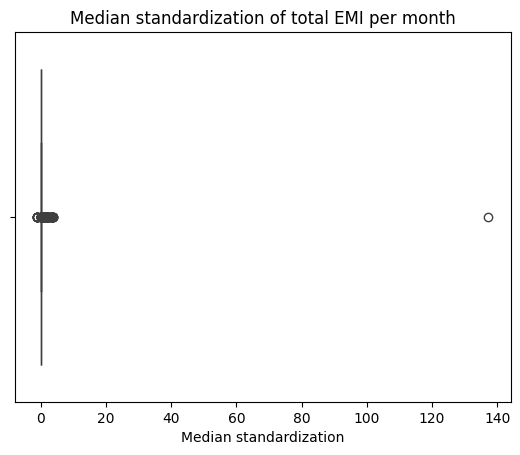

In [1161]:
sns.boxplot(temp.values, orient = 'h')
plt.title('Median standardization of total EMI per month')
plt.xlabel('Median standardization');

Looking at this, only one value looks absurdly big. The rest of the median standardization's could even be considered ok for now.

In [1162]:
temp[temp > 80]

79370    137.282532
Name: Total_EMI_per_month, dtype: float64

Lets convert this value to null and feed it back to the dataset.

In [1163]:
summarize_numerical_column_with_deviation(df, 'Total_EMI_per_month', median_standardization_summary = True)

Column description for Total_EMI_per_month:

count    74509.000000
mean        89.596613
std         82.194196
min          0.000000
25%         28.239753
50%         63.691848
75%        131.616379
max        355.352333
Name: Total_EMI_per_month, dtype: float64

Number of null values: 5491 




Median standardization for Total_EMI_per_month:

count    74509.000000
mean         0.000358
std          0.098864
min         -2.067164
25%          0.000000
50%          0.000000
75%          0.000000
max          2.130177
Name: Total_EMI_per_month, dtype: float64

Number of null values: 5491 




{'Total_EMI_per_month': {'Min. value': np.float64(0.0),
  'Outlier lower range': -126.82518420409671,
  'Outlier upper range': 286.6813162733206,
  'Max. value': np.float64(355.35233277597223)},
 'Median standardization of Total_EMI_per_month': {'Min. value': np.float64(-2.06716384946219),
  'Outlier lower range': 0.0,
  'Outlier upper range': 0.0,
  'Max. value': np.float64(2.130176515218631)},
 'Max. MAD': np.float64(166.68646798280065)}

Now the data looks more appropriate compared to before. There are still 4420 null values which need to be handled here.

The rest of the null values can be filled using forward and backward fill as the EMI's should be highly dependent upon previous month.

In [1164]:
df['Total_EMI_per_month'] = df.groupby('Customer_ID')['Total_EMI_per_month'].transform(forward_backward_fill)

In [1165]:
df['Total_EMI_per_month'].fillna(df['Total_EMI_per_month'].mean(), inplace=True)
df['Total_EMI_per_month'].isnull().sum()

np.int64(0)

#### 19. Amount Invested Monthly

In [1166]:
summary_amount_invested_monthly = summarize_numerical_column_with_deviation(df, 'Amount_invested_monthly', median_standardization_summary = True)

Column description for Amount_invested_monthly:

count    76414.000000
mean       635.977325
std       2040.632147
min          0.000000
25%         74.245943
50%        135.760857
75%        265.164233
max      10000.000000
Name: Amount_invested_monthly, dtype: float64

Number of null values: 3586 




Median standardization for Amount_invested_monthly:

count    76414.000000
mean         9.828240
std         66.473928
min        -55.134421
25%         -0.940762
50%          0.000000
75%          1.158726
max       3152.799634
Name: Amount_invested_monthly, dtype: float64

Number of null values: 3586 




Some values in amount invested monthly are too extreme compared to the rest of the data and thus, can be removed considering them to be erroneous before we do further processing.

In [1167]:
df['Amount_invested_monthly'][df['Amount_invested_monthly'] > 8000] = np.nan

Lets check the distribution again.

In [1168]:
summary_amount_invested_monthly = summarize_numerical_column_with_deviation(df, 'Amount_invested_monthly', median_standardization_summary = True)

Column description for Amount_invested_monthly:

count    72980.000000
mean       195.362720
std        199.994796
min          0.000000
25%         72.024760
50%        128.811819
75%        236.146929
max       1977.326102
Name: Amount_invested_monthly, dtype: float64

Number of null values: 7020 




Median standardization for Amount_invested_monthly:

count    72980.000000
mean         0.462445
std          2.676647
min        -55.134421
25%         -0.962767
50%          0.000000
75%          1.110201
max         97.916014
Name: Amount_invested_monthly, dtype: float64

Number of null values: 7020 




Looks like power law distribution, hopefully these are not erroneous values. Lets leave these non-null values as it is for now. Null values still need to be handled.

In [1169]:
df.groupby('Customer_ID')['Amount_invested_monthly'].transform(return_num_of_modes).value_counts()

Amount_invested_monthly
8    38608
7    28976
6    10112
5     1992
4      208
1       88
3       16
Name: count, dtype: int64

Lets choose the median of values as a decent approximation for null values.

In [1170]:
df['Amount_invested_monthly'] = df.groupby('Customer_ID')['Amount_invested_monthly'].transform(lambda x: x.fillna(x.median()))

#### 20. Payment Behaviour

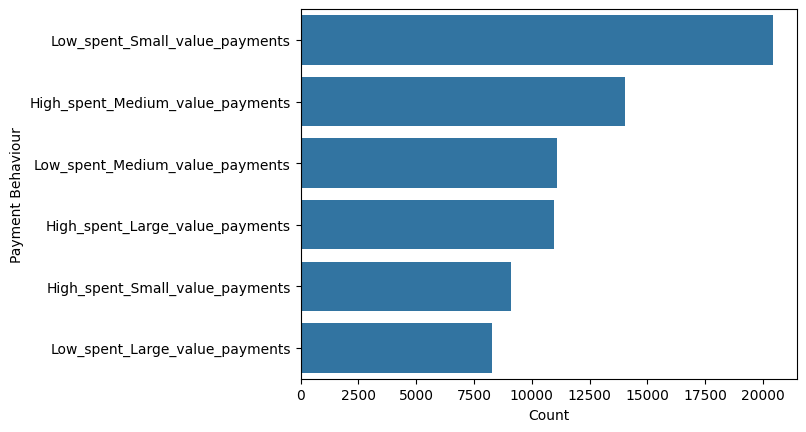

In [1171]:
payment_behaviour_count = df['Payment_Behaviour'].value_counts()
sns.barplot(x = payment_behaviour_count.values, y = payment_behaviour_count.index, orient = 'h')
plt.xlabel('Count')
plt.ylabel('Payment Behaviour');

In [1172]:
df['Payment_Behaviour'].isnull().sum()

np.int64(6139)

7600 of null values present.

In [1173]:
df.groupby('Customer_ID')['Payment_Behaviour'].nunique().value_counts()

Payment_Behaviour
4    4171
5    2586
3    2372
2     459
6     393
1      19
Name: count, dtype: int64

In [1174]:
df.groupby('Customer_ID')['Payment_Behaviour'].agg(return_num_of_modes).value_counts()

Payment_Behaviour
1    7185
2    1822
3     885
4      92
5      11
6       5
Name: count, dtype: int64

The number of modes vary, if the number of mode is 1 then we can use that for imputation else forward fill and backward fill can be used.

In [1175]:
df['Payment_Behaviour'] = df.groupby('Customer_ID')['Payment_Behaviour'].transform(lambda x: return_mode(x) if len(x.mode()) == 1 else forward_backward_fill(x))

In [1176]:
df['Payment_Behaviour'].isnull().sum()

np.int64(0)

#### 21. Monthly Balance

In [1177]:
summary_monthly_balance = summarize_numerical_column_with_deviation(df, 'Monthly_Balance', median_standardization_summary = True)

Column description for Monthly_Balance:

count    79031.000000
mean       402.302726
std        213.695307
min          0.007760
25%        270.154076
50%        336.452745
75%        469.685963
max       1602.040519
Name: Monthly_Balance, dtype: float64

Number of null values: 969 




Median standardization for Monthly_Balance:

count    79031.000000
mean        -0.470651
std          2.485421
min        -68.498024
25%         -1.135687
50%          0.000000
75%          0.931241
max         21.453890
Name: Monthly_Balance, dtype: float64

Number of null values: 969 




There are 1209 null values. Looking at the column as a whole the distribution looks ok and considering the fact that we can't decide exactly on a threshold on median standardization without domain expertise. We will leave the non-null values as it for now.

In [1178]:
df.groupby('Customer_ID')['Monthly_Balance'].nunique().value_counts()

Monthly_Balance
8    9225
7     621
6     125
5      19
4       9
3       1
Name: count, dtype: int64

Since there might be skewness within the data we can use median to fill the null values.

In [1179]:
df['Monthly_Balance'] = df.groupby('Customer_ID')['Monthly_Balance'].transform(lambda x: x.fillna(x.median()))

### Deleting unnecessary columns

In [1180]:
df.columns

Index(['Unnamed: 0', 'Customer_ID', 'Month', 'Age', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'Last_Loan_9', 'Last_Loan_8', 'Last_Loan_7',
       'Last_Loan_6', 'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3',
       'Last_Loan_2', 'Last_Loan_1'],
      dtype='object')

Month column is not needed anymore and can be dropped. We will keep customer id as it is for now so that it can be used later on when doing train-test splits.

df.drop(columns = ['Month'], inplace = True)

In [1181]:
df = df.sample(frac = 1) #shuffle data

### Rearranging the columns

In [1182]:
df.columns

Index(['Unnamed: 0', 'Customer_ID', 'Month', 'Age', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Credit_Score', 'Last_Loan_9', 'Last_Loan_8', 'Last_Loan_7',
       'Last_Loan_6', 'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3',
       'Last_Loan_2', 'Last_Loan_1'],
      dtype='object')

In [1183]:
df = df.loc[:, ['Customer_ID', 'Age', 'Occupation', 'Annual_Income',
       'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card',
       'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date',
       'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance', 'Last_Loan_9', 'Last_Loan_8', 'Last_Loan_7',
       'Last_Loan_6', 'Last_Loan_5', 'Last_Loan_4', 'Last_Loan_3',
       'Last_Loan_2', 'Last_Loan_1',
       'Credit_Score']]

### Checking the columns

In [1184]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 80000 entries, 29210 to 53491
Data columns (total 32 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Customer_ID               80000 non-null  object 
 1   Age                       80000 non-null  int64  
 2   Occupation                80000 non-null  object 
 3   Annual_Income             80000 non-null  float64
 4   Monthly_Inhand_Salary     80000 non-null  float64
 5   Num_Bank_Accounts         80000 non-null  int64  
 6   Num_Credit_Card           80000 non-null  int64  
 7   Interest_Rate             80000 non-null  float64
 8   Num_of_Loan               80000 non-null  int64  
 9   Delay_from_due_date       80000 non-null  int64  
 10  Num_of_Delayed_Payment    80000 non-null  int64  
 11  Changed_Credit_Limit      80000 non-null  float64
 12  Num_Credit_Inquiries      80000 non-null  int64  
 13  Credit_Mix                80000 non-null  object 
 14  Outstan

In [1185]:
df.isnull().sum()

Customer_ID                 0
Age                         0
Occupation                  0
Annual_Income               0
Monthly_Inhand_Salary       0
Num_Bank_Accounts           0
Num_Credit_Card             0
Interest_Rate               0
Num_of_Loan                 0
Delay_from_due_date         0
Num_of_Delayed_Payment      0
Changed_Credit_Limit        0
Num_Credit_Inquiries        0
Credit_Mix                  0
Outstanding_Debt            0
Credit_Utilization_Ratio    0
Credit_History_Age          0
Payment_of_Min_Amount       0
Total_EMI_per_month         0
Amount_invested_monthly     0
Payment_Behaviour           0
Monthly_Balance             0
Last_Loan_9                 0
Last_Loan_8                 0
Last_Loan_7                 0
Last_Loan_6                 0
Last_Loan_5                 0
Last_Loan_4                 0
Last_Loan_3                 0
Last_Loan_2                 0
Last_Loan_1                 0
Credit_Score                0
dtype: int64

In [1186]:
# # Adjust tolerances
# income_tolerance = 0.05  # 5%
# credit_utilization_tolerance = 0.1  # 10%

# # Recreate "buckets" for numeric columns with adjusted tolerances
# df['Income_Range'] = (df['Annual_Income'] // (df['Annual_Income'].mean() * income_tolerance)).astype(int)

# # Define a minimal subset for detecting duplicates
# subset_columns = [
#     'Customer_ID', 
#     'Income_Range', 
#     'Age', 
#     'Credit_Score'
# ]

# # Group by Customer_ID and detect duplicates within each group
# df['is_duplicate'] = df.groupby('Customer_ID').apply(
#     lambda group: group.duplicated(subset=subset_columns, keep='first')
# ).reset_index(level=0, drop=True)

# # Inspect rows marked as duplicates
# removed_rows = df[df['is_duplicate']]
# print("Removed Rows:")
# print(removed_rows)

# # Drop duplicate records and reset index
# df = df[~df['is_duplicate']].drop(columns=['is_duplicate', 'Income_Range'])
# df.reset_index(drop=True, inplace=True)

# # Check the class distribution after removing duplicates
# print("Class Distribution After Removing Duplicates:")
# print(df['Credit_Score'].value_counts())

# # Final DataFrame information
# print(f"Total Rows: {len(df)}")
# print("Top Rows:")
# print(df.head())
# print(df.info())


# df.duplicated().sum()

In [1187]:
df.describe()

,Age,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Total_EMI_per_month,Amount_invested_monthly,Monthly_Balance
count,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000
mean,33.365625,5.076891e+04,4196.339376,5.366462,5.541462,14.560100,3.552200,21.104625,13.333825,10.357267,5.785762,1427.878089,32.303583,220.953800,90.146455,193.440983,403.329099
std,10.749782,9.101956e+04,3193.986148,2.583602,2.062664,8.737674,2.444535,14.875335,6.266640,6.779613,3.864421,1156.913930,5.120211,99.772071,81.517920,195.158250,214.257315
min,14.000000,7.005930e+03,319.556250,0.000000,0.000000,1.000000,0.000000,-5.000000,0.000000,-6.490000,0.000000,0.540000,20.000000,1.000000,0.000000,0.000000,0.007760
25%,25.000000,1.928073e+04,1626.525000,3.000000,4.000000,7.000000,2.000000,10.000000,9.000000,5.290000,3.000000,563.100000,28.063496,144.000000,29.236416,73.421405,270.353013
50%,33.000000,3.682100e+04,3074.046250,6.000000,5.000000,13.000000,3.000000,18.000000,14.000000,9.360000,5.000000,1167.045000,32.343787,219.000000,65.972954,129.218620,337.025036
75%,42.000000,7.167600e+04,5957.715000,7.000000,7.000000,20.000000,5.000000,28.000000,18.000000,14.860000,9.000000,1953.232500,36.515261,302.000000,130.457752,233.556222,471.611204
max,56.000000,2.339320e+07,15204.633333,11.000000,11.000000,34.000000,9.000000,67.000000,28.000000,36.970000,17.000000,4998.070000,50.000000,404.000000,355.352333,1977.326102,1602.040519


### Exporting the data

In [ ]:
df.to_csv('../data/Credit_score_cleaned_data.csv', index = False)

## Conclusion:

In this notebook, we were able to observe and accomplish following things:  
- Using standard outlier detection techniques like IQR in conjuction with lesser used techniques like median standardization to perform deep dive on the columns by taking advantage of the inherent chronolgical structure of the data to make better educated guesses about how to clean the data and fill the missing values.
- We used techniques like string based functions of pandas to detect unclean data and do feature engineering.
- It was highlighted how domain expertise can help streamline the data cleaning process and where it might help us make better choices.
- This notebook will be followed by a predictive modelling notebook which will contain EDA, feature engineering and tree based predictive modelling.